# Threshold Analysis — Filtering 5m Candles into Trading Signals

**Goal:** Design a threshold mechanism that filters 5-minute candles into trading
opportunities — moments of fear, excitement, or irrational overreaction. We evaluate
7 candidate formulas, sweep thresholds to hit ~600 signals/month across all symbols,
validate on held-out data, and decide whether thresholds should be static or dynamic.

## Section 0: Setup & Config

In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os, glob, csv
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats as sp_stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from tqdm.auto import tqdm

# Plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams.update({
    "figure.figsize": (14, 6),
    "figure.dpi": 100,
    "savefig.dpi": 150,
    "savefig.bbox": "tight",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

# Constants
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

MIN_ROWS = 52_000              # ~6 months of 5m candles
ROLLING_WINDOW = 12            # 1 hour of 5m candles
TARGET_SIGNALS_MONTH = 600     # target signals per month across all symbols

print("Setup complete.")

Setup complete.


## Section 1: Data Loading & Train/Val Split

In [24]:
# --- Load all perpetual USDT 5m CSVs ---
all_csvs = sorted(DATA_DIR.glob("*/5m.csv"))
print(f"Found {len(all_csvs)} symbols with 5m.csv")

raw_frames = {}
for csv_path in tqdm(all_csvs, desc="Loading CSVs"):
    sym = csv_path.parent.name
    if "_" in sym or sym.endswith("BUSD"):
        continue
    df = pd.read_csv(
        csv_path,
        names=["open_time", "open", "high", "low", "close", "volume",
               "close_time", "quote_volume", "trades",
               "taker_buy_volume", "taker_buy_quote_volume"],
        header=0,
        dtype={"open": str, "high": str, "low": str, "close": str,
               "volume": str, "quote_volume": str,
               "taker_buy_volume": str, "taker_buy_quote_volume": str},
    )
    if len(df) < MIN_ROWS:
        continue
    for col in ["open", "high", "low", "close", "volume", "quote_volume",
                "taker_buy_volume", "taker_buy_quote_volume"]:
        df[col] = df[col].astype(float)
    df["trades"] = df["trades"].astype(int)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    df = df.sort_values("open_time").reset_index(drop=True)
    raw_frames[sym] = df

symbols = sorted(raw_frames.keys())
print(f"\n{len(symbols)} symbols passed filters (>= {MIN_ROWS} rows, perpetual USDT)")
print(f"Date range example ({symbols[0]}): "
      f"{raw_frames[symbols[0]]['open_time'].iloc[0]} — "
      f"{raw_frames[symbols[0]]['open_time'].iloc[-1]}")

Found 162 symbols with 5m.csv


Loading CSVs:   0%|          | 0/162 [00:00<?, ?it/s]


118 symbols passed filters (>= 52000 rows, perpetual USDT)
Date range example (1000SHIBUSDT): 2021-05-10 17:35:00 — 2021-12-31 23:55:00


In [25]:
# --- Chronological 50/50 split per symbol ---
train_frames = {}
val_frames = {}
for sym in symbols:
    df = raw_frames[sym]
    mid = len(df) // 2
    train_frames[sym] = df.iloc[:mid].copy().reset_index(drop=True)
    val_frames[sym] = df.iloc[mid:].copy().reset_index(drop=True)

train_rows = sum(len(v) for v in train_frames.values())
val_rows = sum(len(v) for v in val_frames.values())
print(f"Train: {train_rows:,} rows | Val: {val_rows:,} rows")
print(f"Train period example ({symbols[0]}): "
      f"{train_frames[symbols[0]]['open_time'].iloc[0]} — "
      f"{train_frames[symbols[0]]['open_time'].iloc[-1]}")
print(f"Val   period example ({symbols[0]}): "
      f"{val_frames[symbols[0]]['open_time'].iloc[0]} — "
      f"{val_frames[symbols[0]]['open_time'].iloc[-1]}")

Train: 7,839,271 rows | Val: 7,839,287 rows
Train period example (1000SHIBUSDT): 2021-05-10 17:35:00 — 2021-09-05 08:40:00
Val   period example (1000SHIBUSDT): 2021-09-05 08:45:00 — 2021-12-31 23:55:00


## Section 2: Compute 7 Candidate Threshold Formulas

| Formula | Column | Intuition |
|---------|--------|-----------|
| Volume Spike | `vol_spike` | Sudden participation surge |
| Price Move | `price_move` | Candle body magnitude |
| Range Spike | `range_spike` | Volatility explosion |
| Trade Count Spike | `trade_spike` | Retail frenzy |
| Quote Vol Spike | `qvol_spike` | USD value surge |
| Combined Z-Score | `combined_z` | Multi-dimension confirmation |
| Taker Imbalance | `taker_imbalance` | Directional aggression |

In [26]:
METRIC_COLS = [
    "vol_spike", "price_move", "range_spike", "trade_spike",
    "qvol_spike", "combined_z", "taker_imbalance",
]


def compute_threshold_metrics(df: pd.DataFrame, window: int = ROLLING_WINDOW) -> pd.DataFrame:
    """Add 7 threshold metric columns to a DataFrame of 5m candles."""
    # Volume spike: current volume / rolling mean
    vol_rm = df["volume"].rolling(window, min_periods=1).mean()
    df["vol_spike"] = df["volume"] / vol_rm.replace(0, np.nan)

    # Price move: absolute body relative to open
    df["price_move"] = (df["close"] - df["open"]).abs() / df["open"].replace(0, np.nan)

    # Range spike: (high-low)/open normalized by its rolling mean
    range_ratio = (df["high"] - df["low"]) / df["open"].replace(0, np.nan)
    range_rm = range_ratio.rolling(window, min_periods=1).mean()
    df["range_spike"] = range_ratio / range_rm.replace(0, np.nan)

    # Trade count spike
    trades_rm = df["trades"].rolling(window, min_periods=1).mean()
    df["trade_spike"] = df["trades"] / trades_rm.replace(0, np.nan)

    # Quote volume spike
    qvol_rm = df["quote_volume"].rolling(window, min_periods=1).mean()
    df["qvol_spike"] = df["quote_volume"] / qvol_rm.replace(0, np.nan)

    # Combined z-score: expanding standardization of avg(vol_spike, price_move_z, range_spike)
    # Use expanding stats to avoid look-ahead bias
    raw_combo = (df["vol_spike"].fillna(1) + df["range_spike"].fillna(1)) / 2
    exp_mean = raw_combo.expanding(min_periods=window).mean()
    exp_std = raw_combo.expanding(min_periods=window).std()
    df["combined_z"] = (raw_combo - exp_mean) / exp_std.replace(0, np.nan)

    # Taker imbalance: how far taker buy ratio is from 0.5
    taker_ratio = df["taker_buy_volume"] / df["volume"].replace(0, np.nan)
    df["taker_imbalance"] = (taker_ratio - 0.5).abs()

    return df


# Apply to train and val frames
for sym in tqdm(symbols, desc="Computing metrics (train)"):
    train_frames[sym] = compute_threshold_metrics(train_frames[sym])
for sym in tqdm(symbols, desc="Computing metrics (val)"):
    val_frames[sym] = compute_threshold_metrics(val_frames[sym])

print(f"Metrics computed. Example columns: {list(train_frames[symbols[0]].columns[-7:])}")

Computing metrics (train):   0%|          | 0/118 [00:00<?, ?it/s]

Computing metrics (val):   0%|          | 0/118 [00:00<?, ?it/s]

Metrics computed. Example columns: ['vol_spike', 'price_move', 'range_spike', 'trade_spike', 'qvol_spike', 'combined_z', 'taker_imbalance']


## Section 3: Metric Distributions

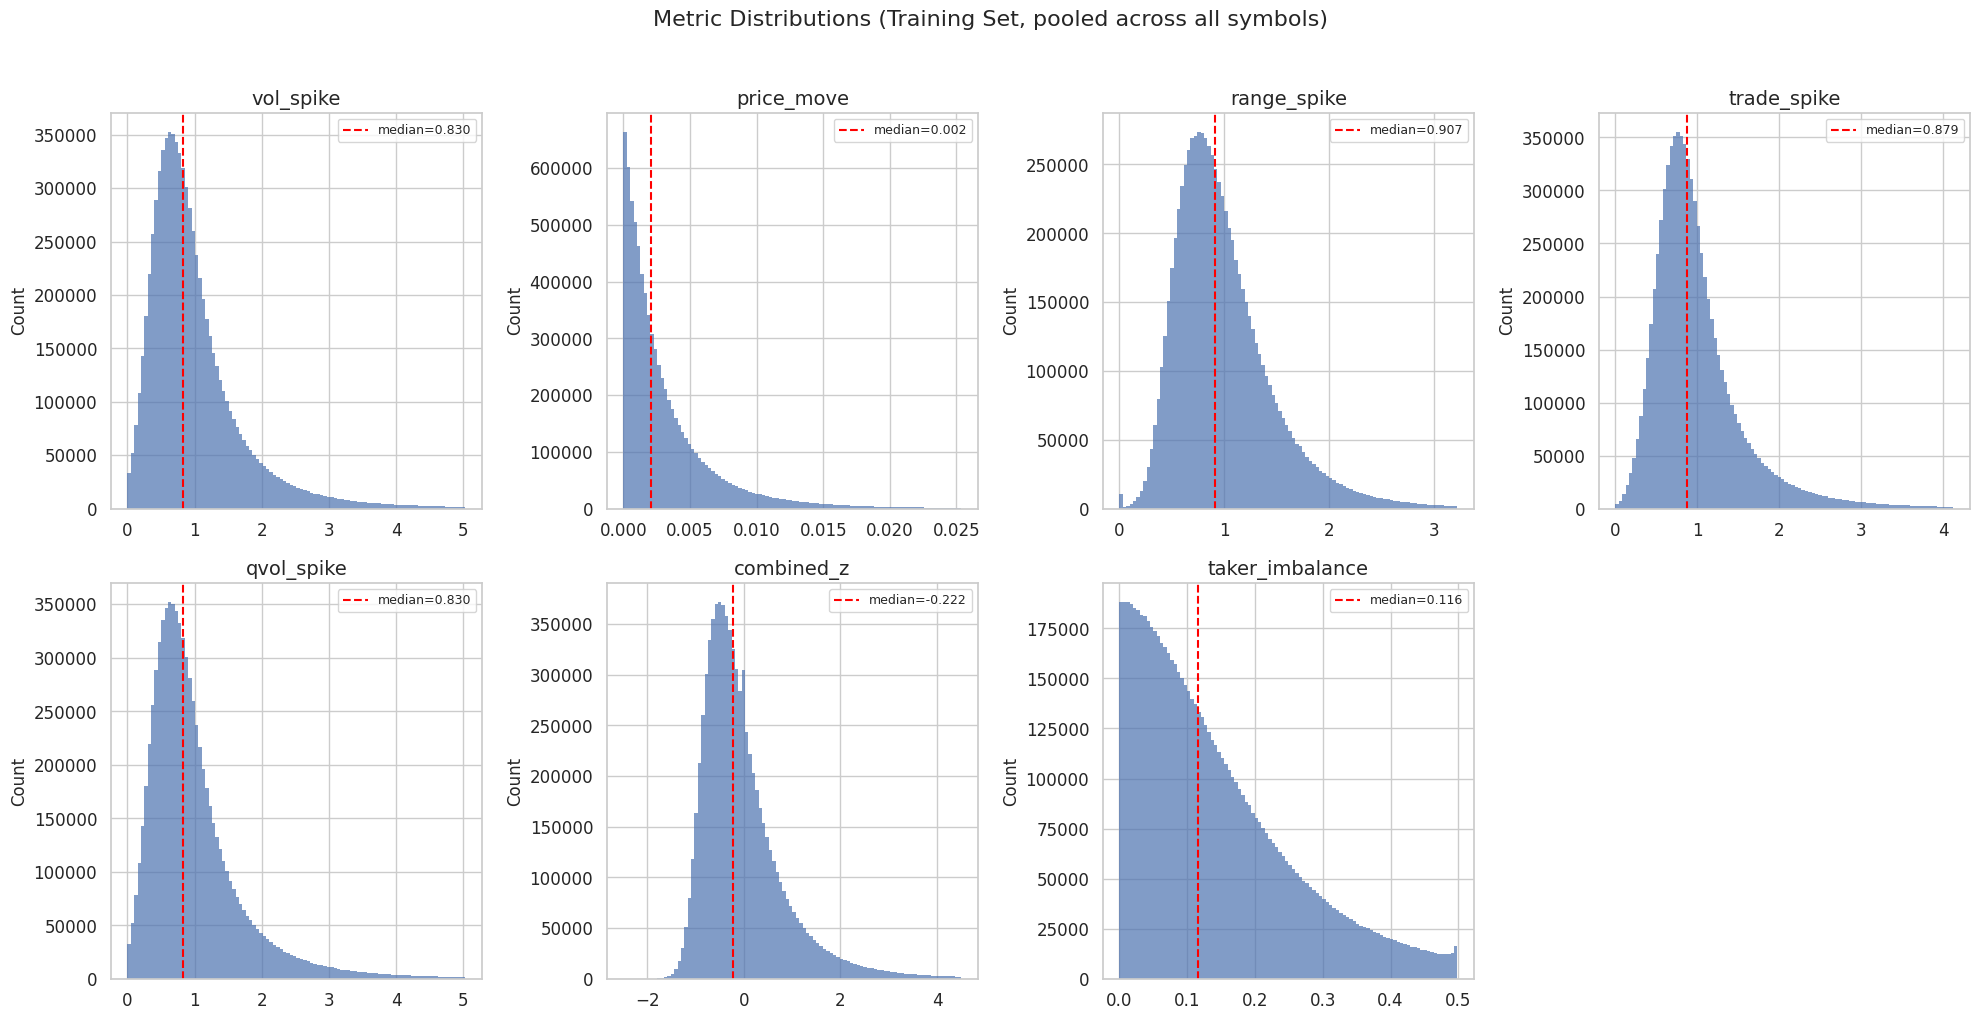

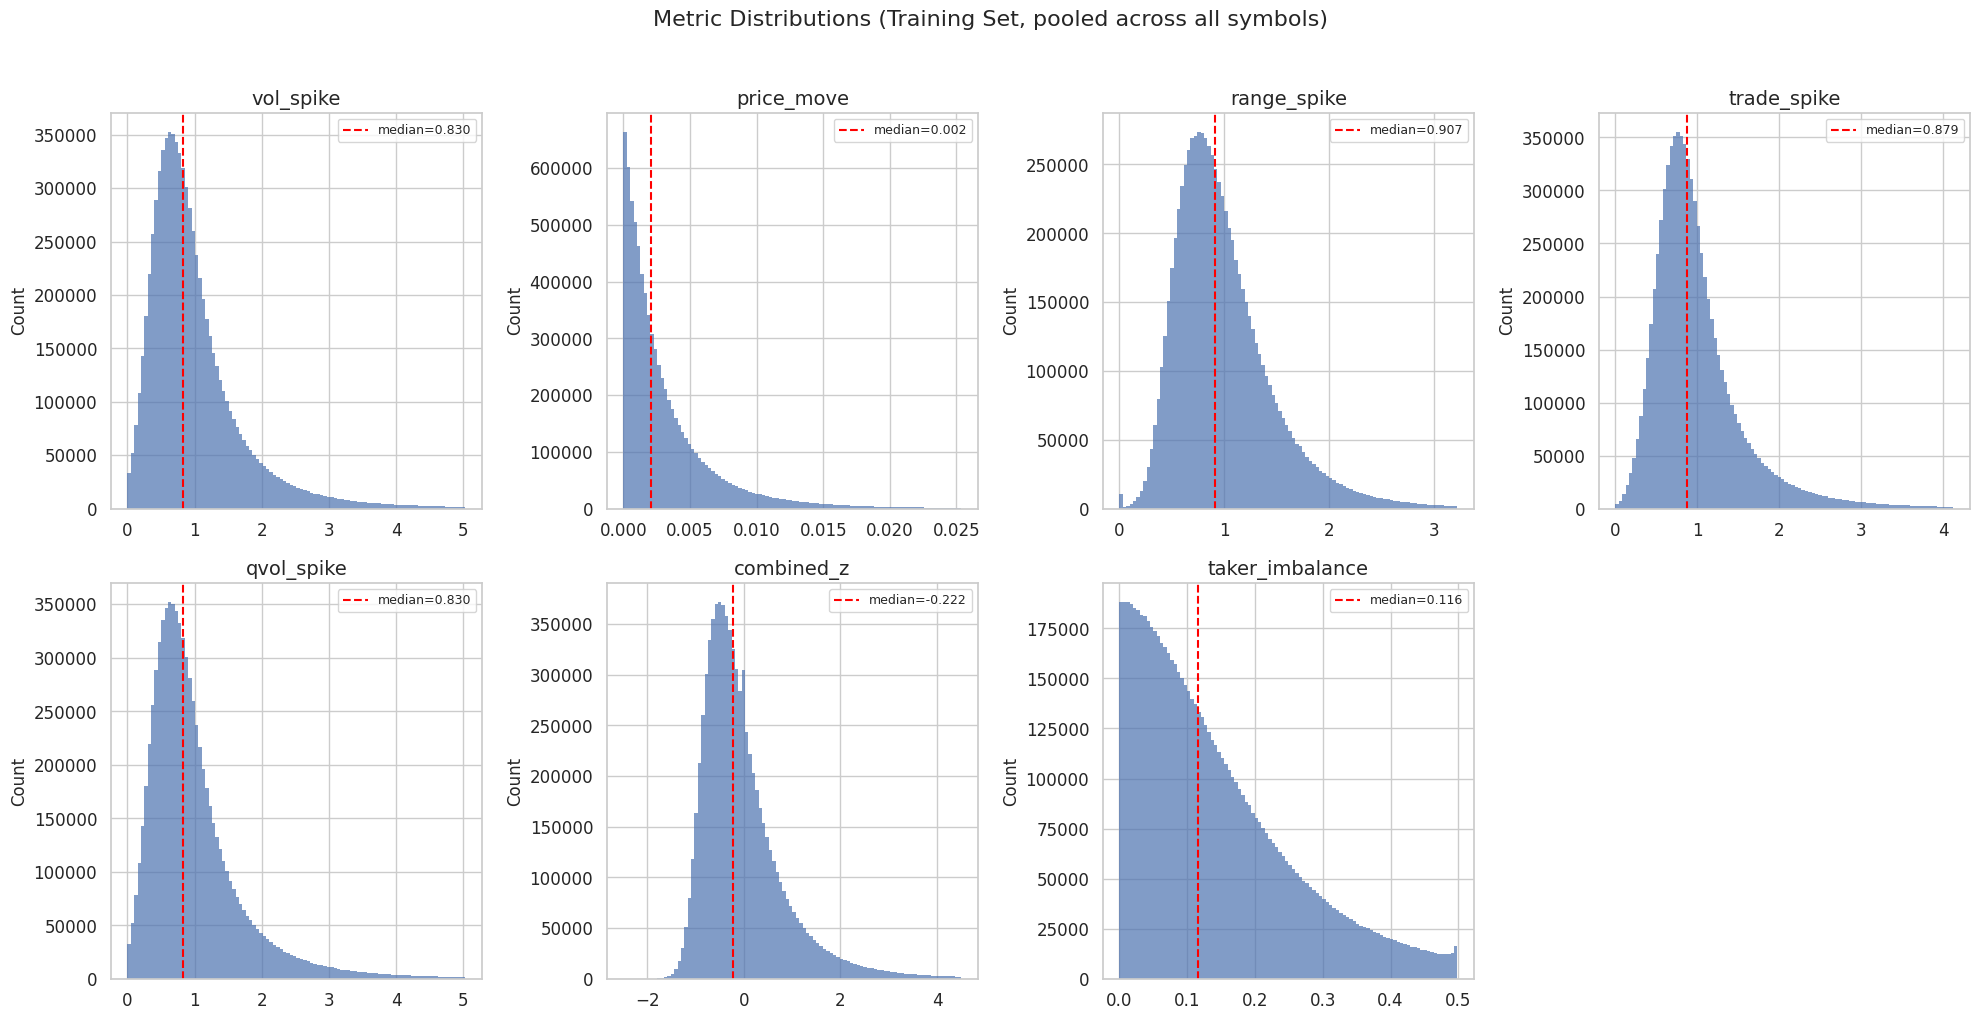

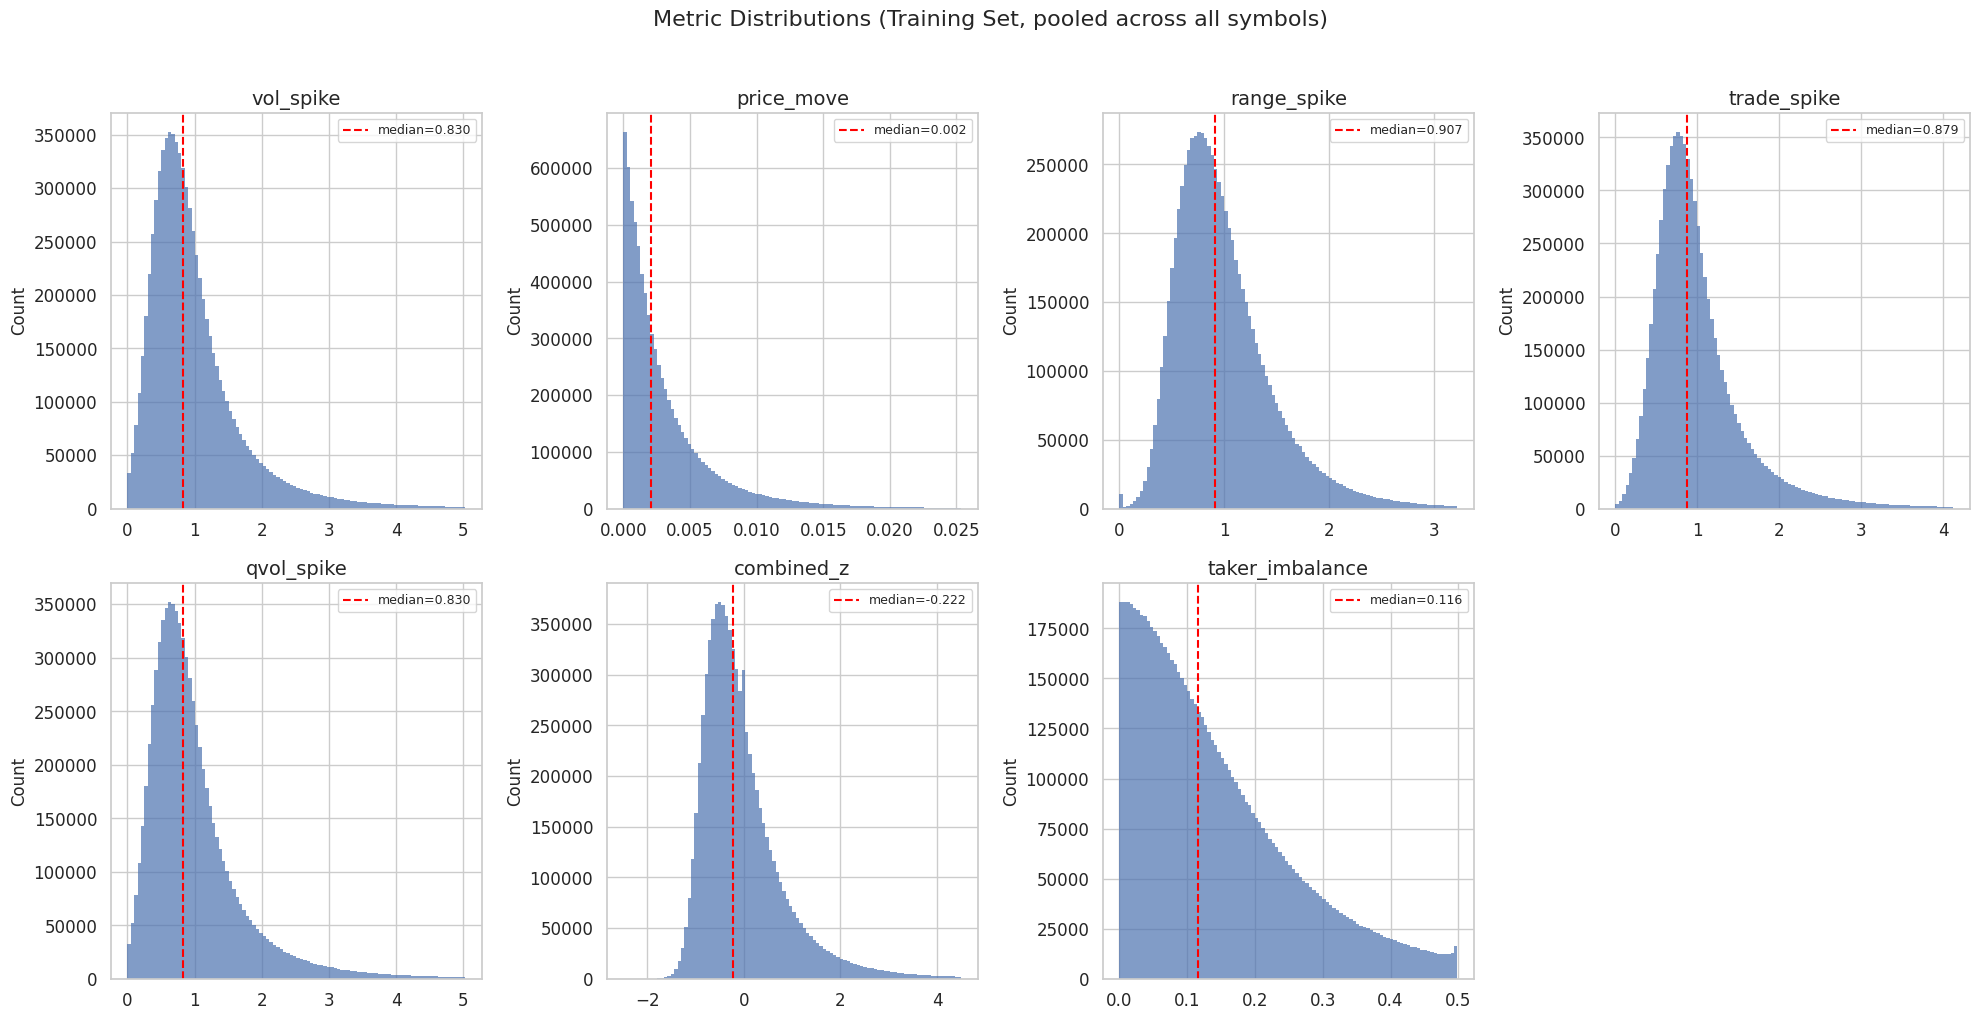

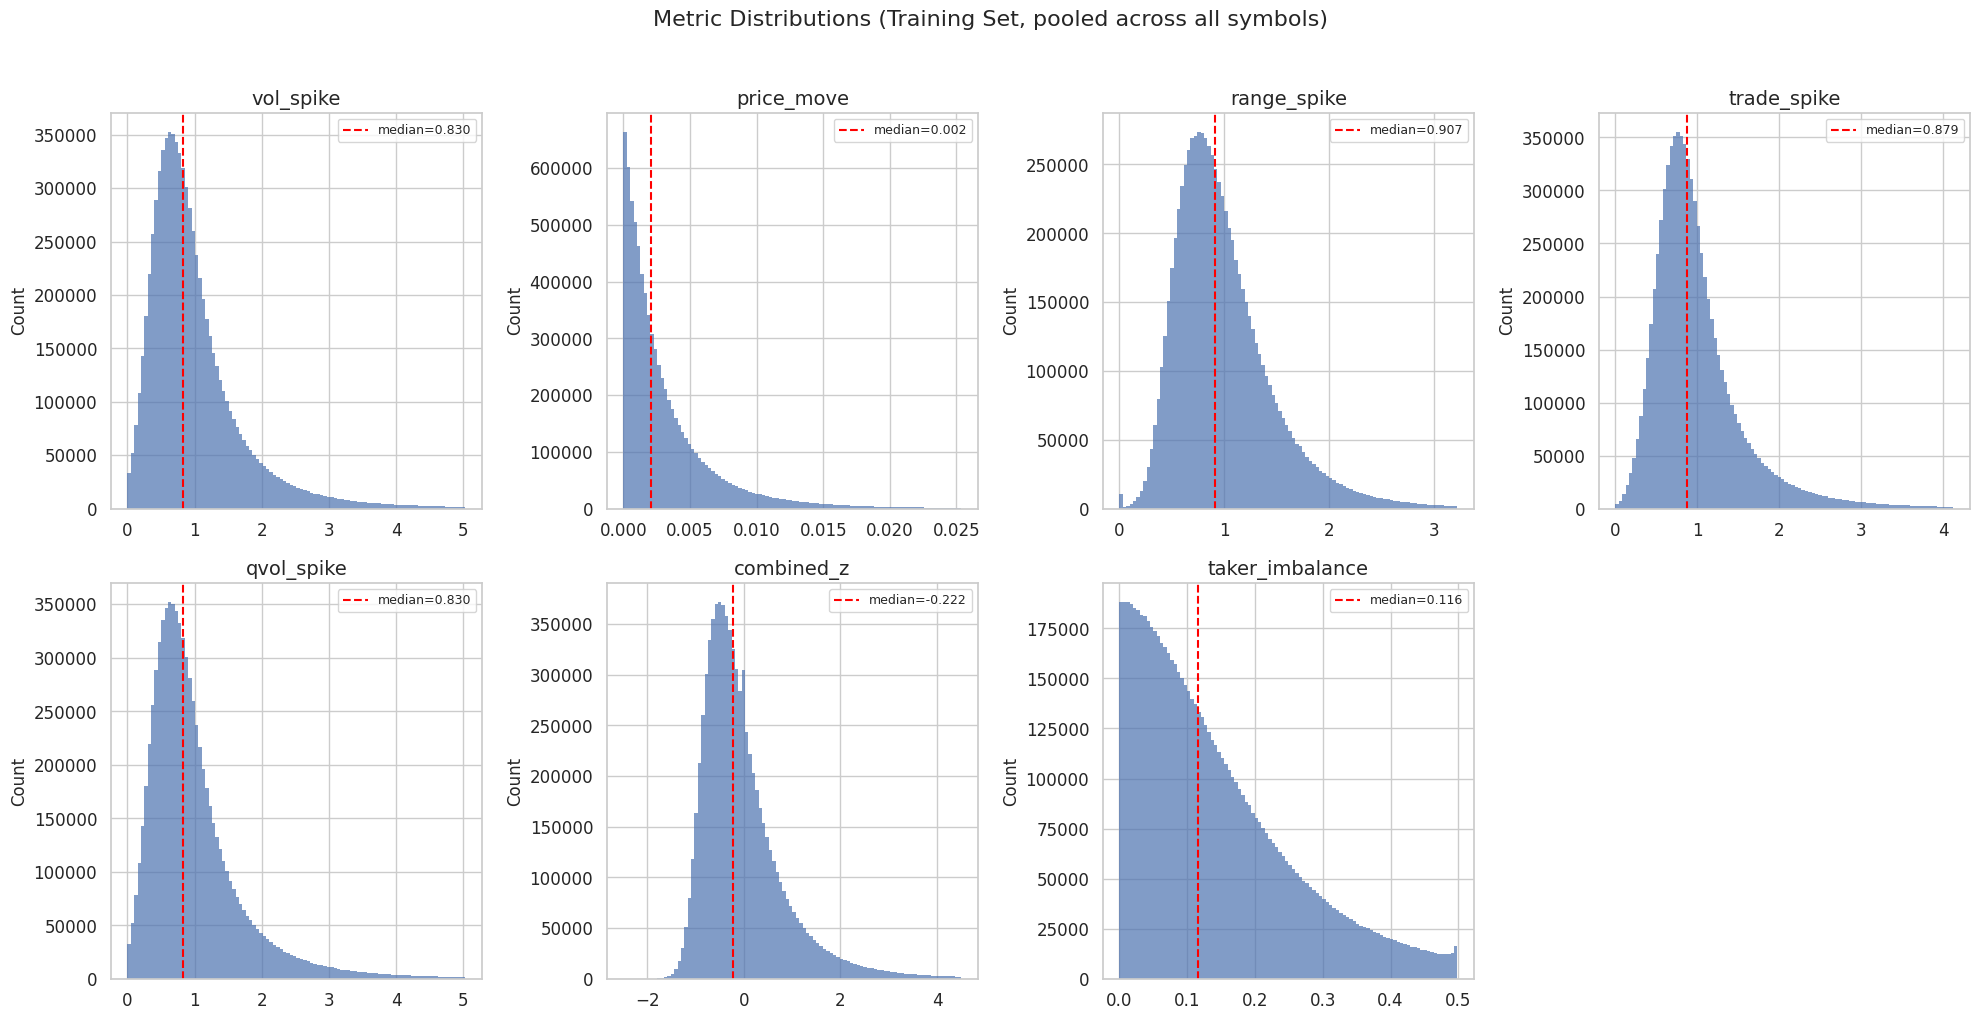

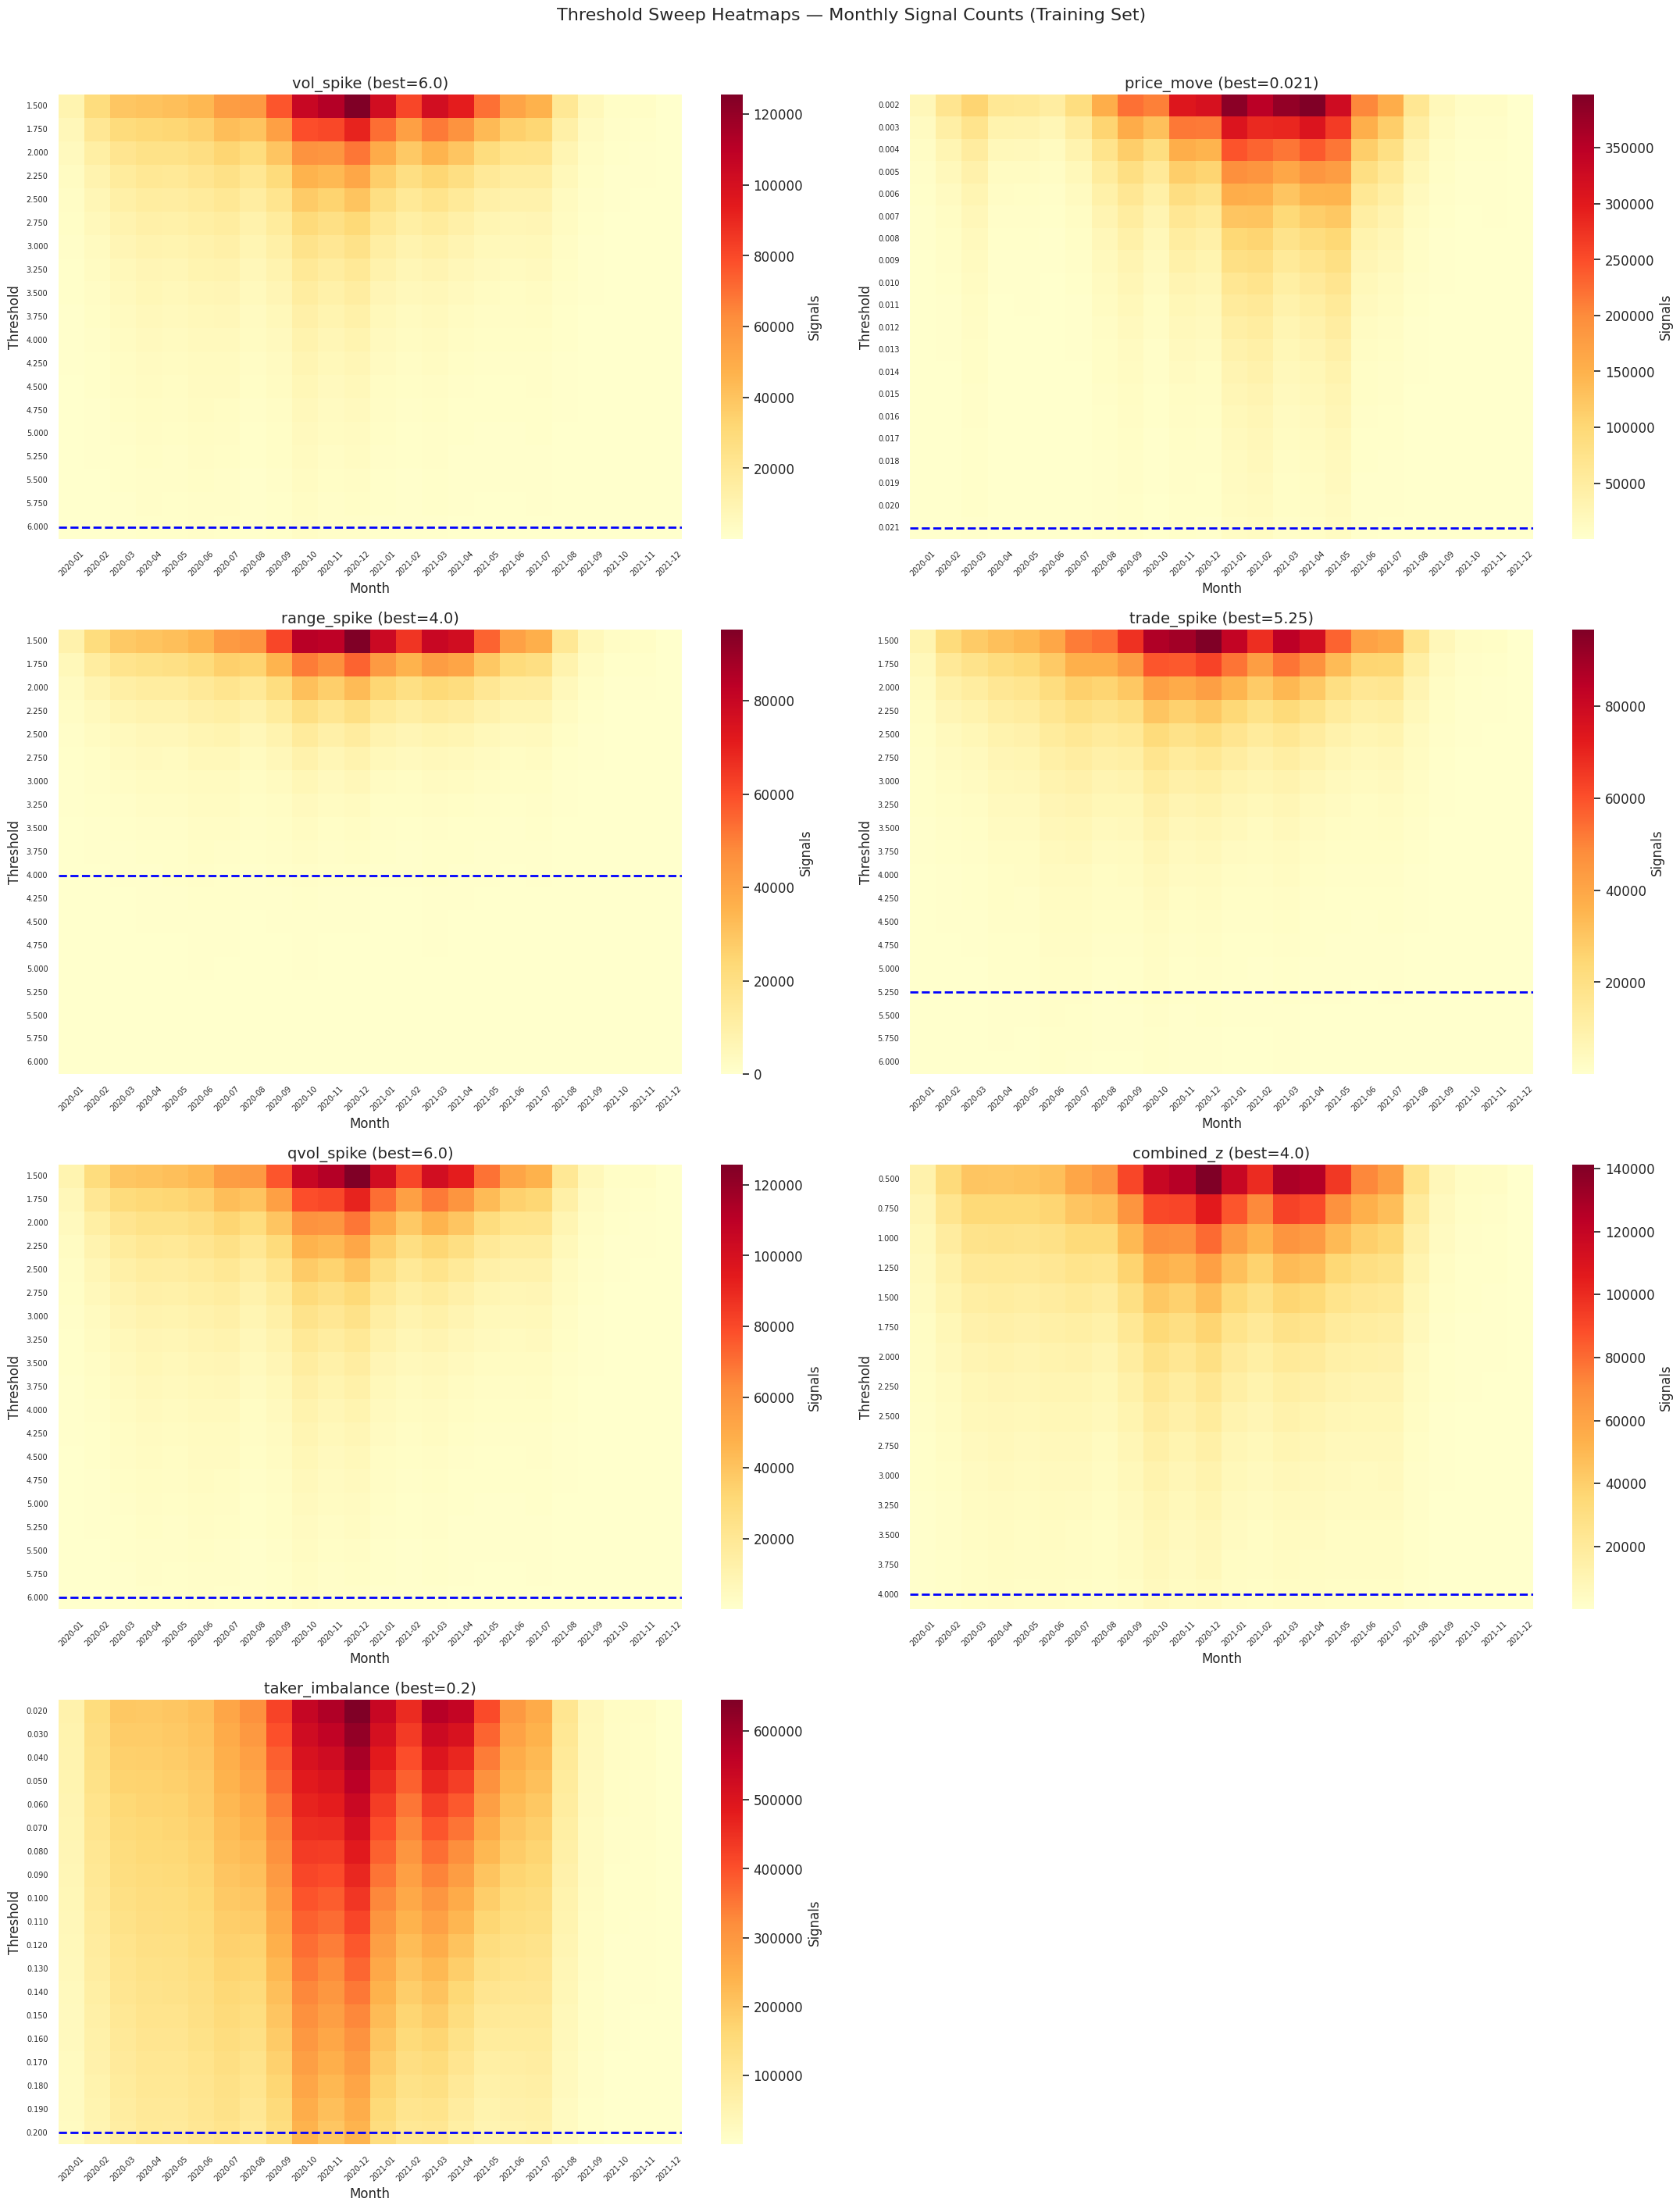

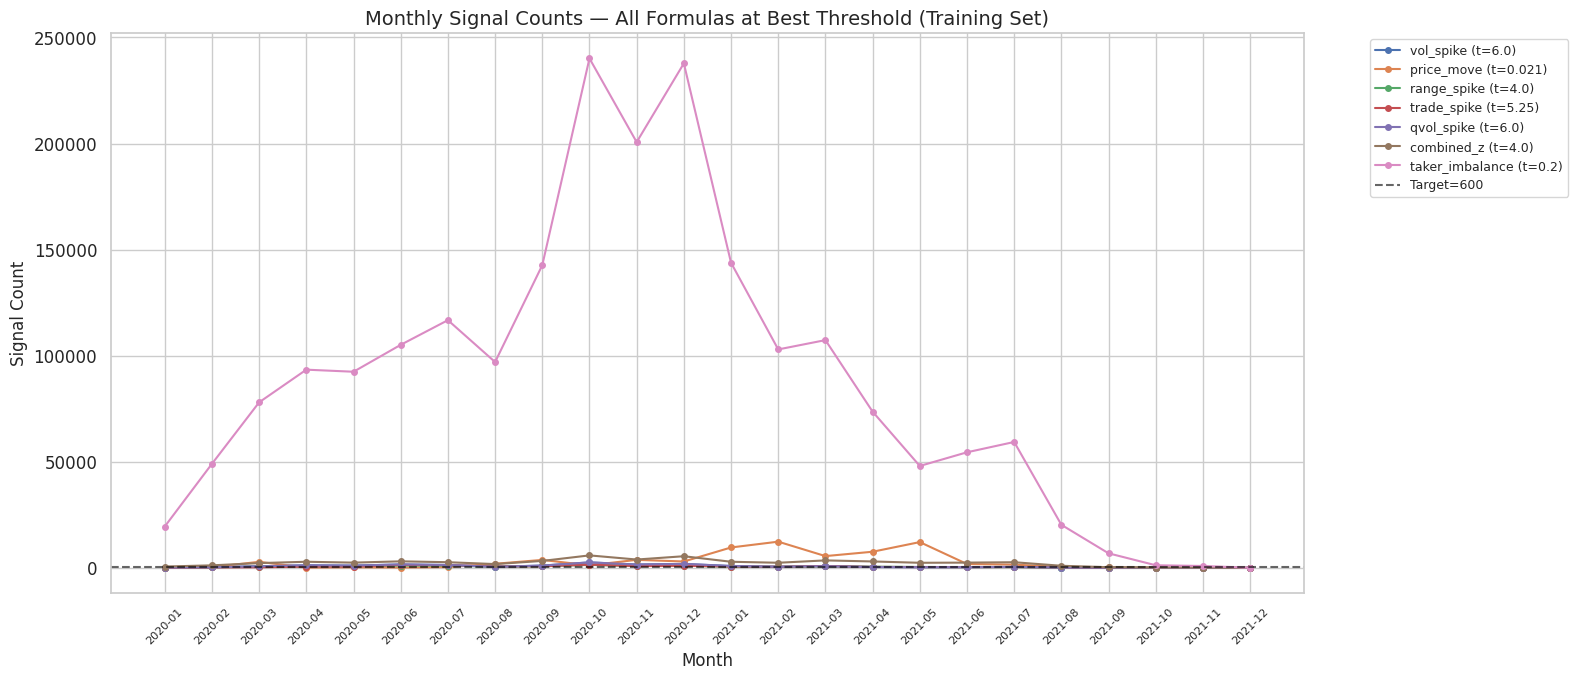

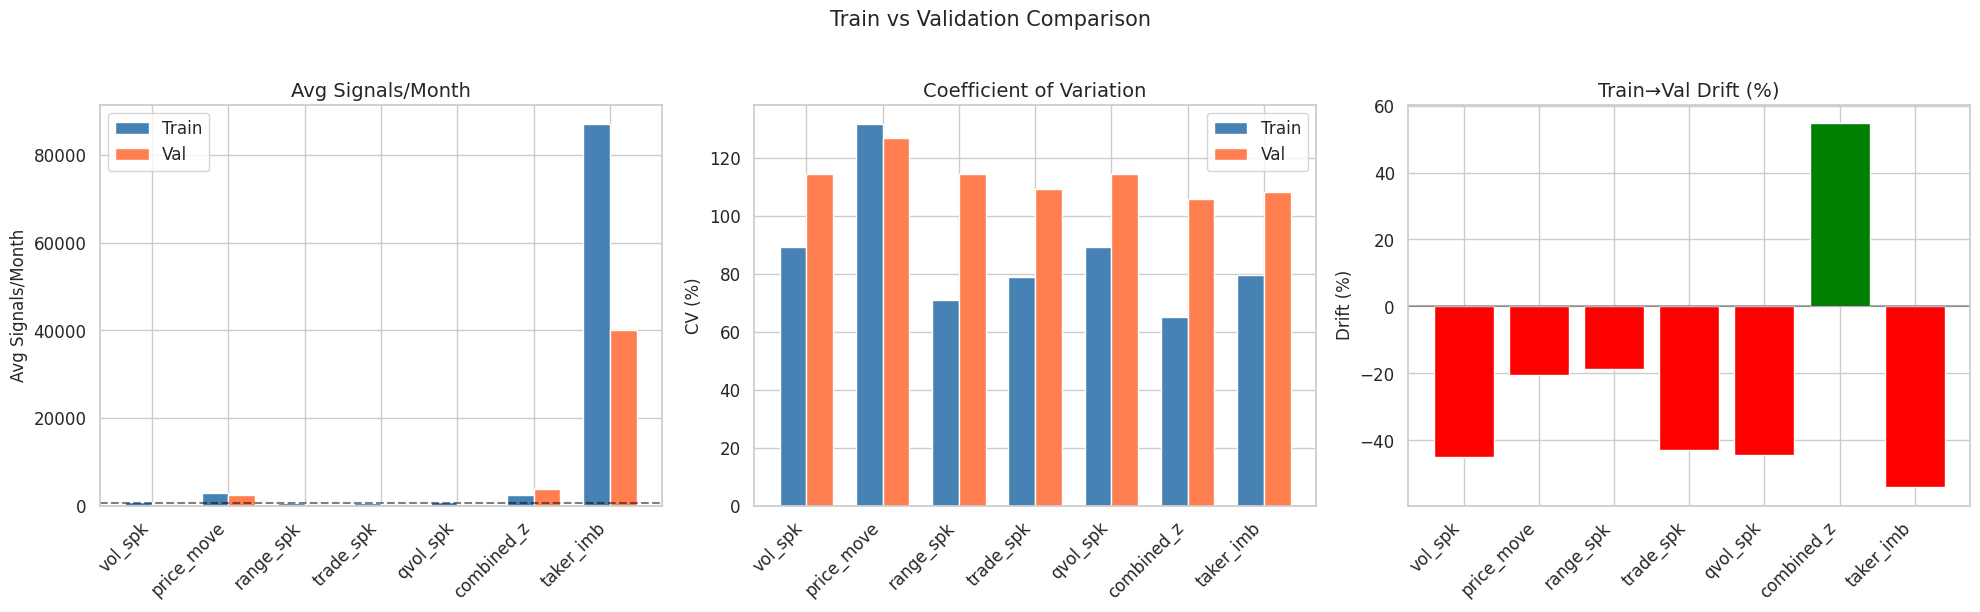

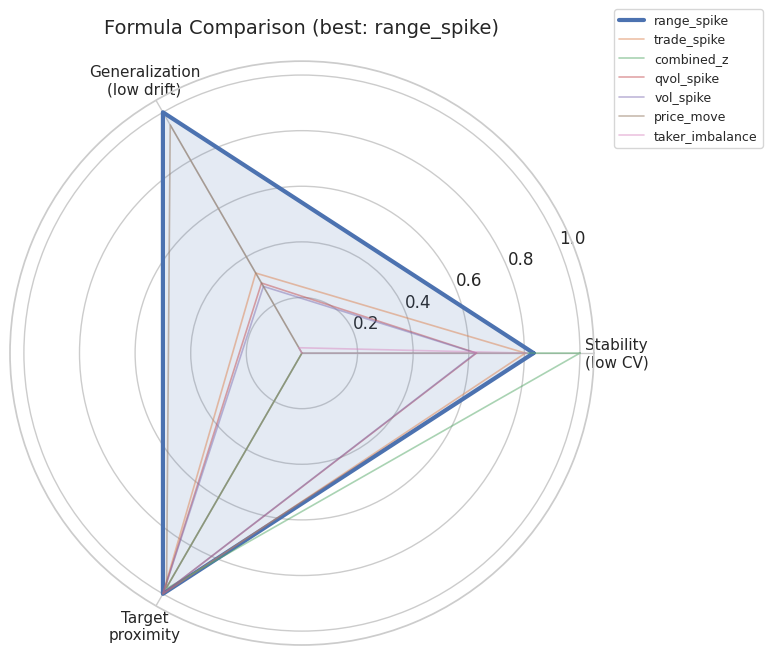

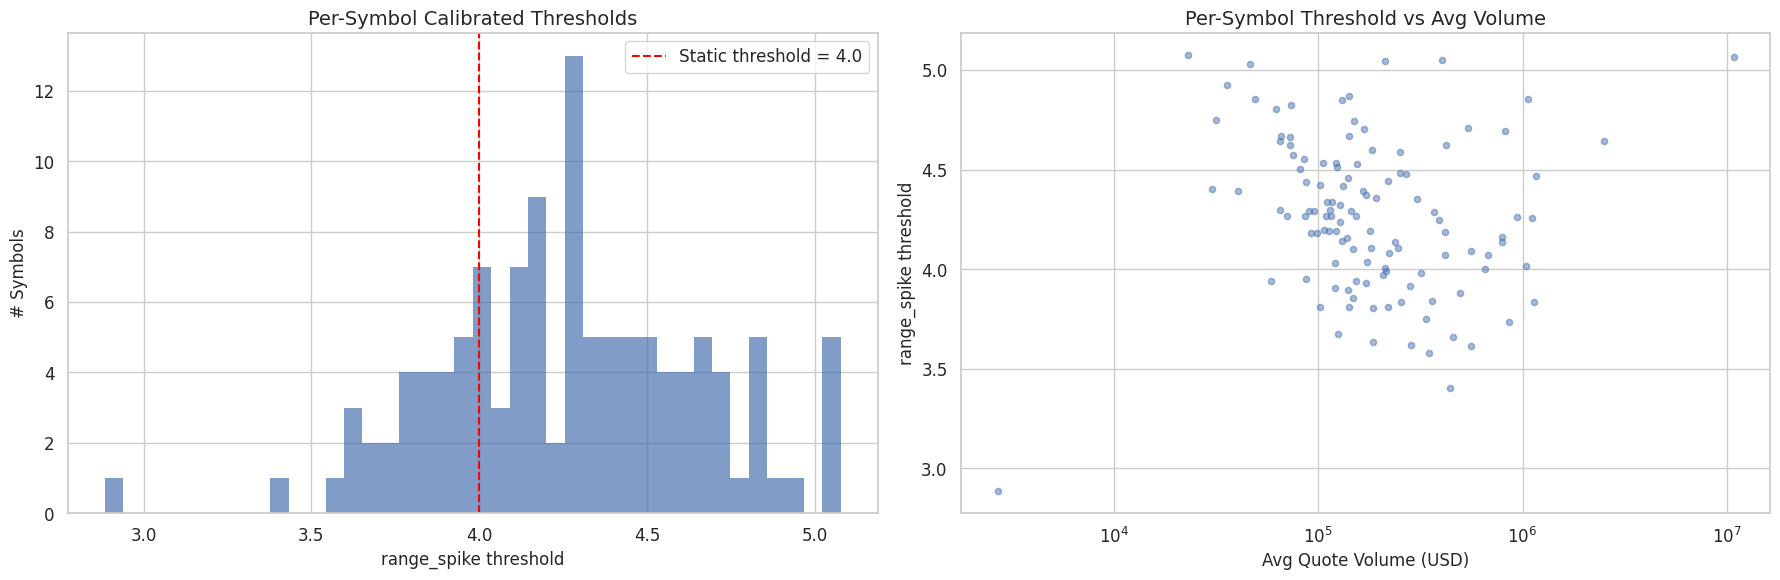

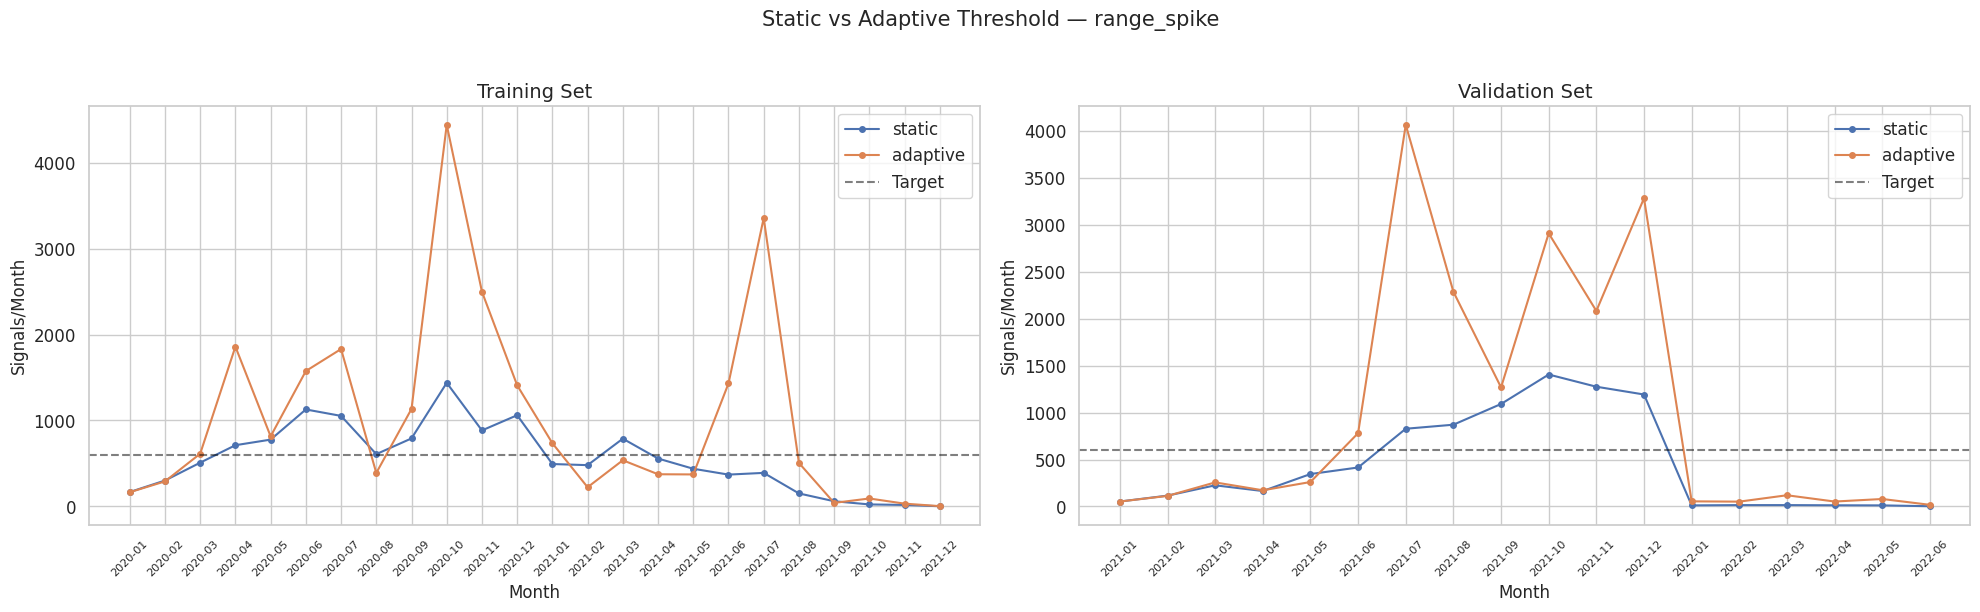

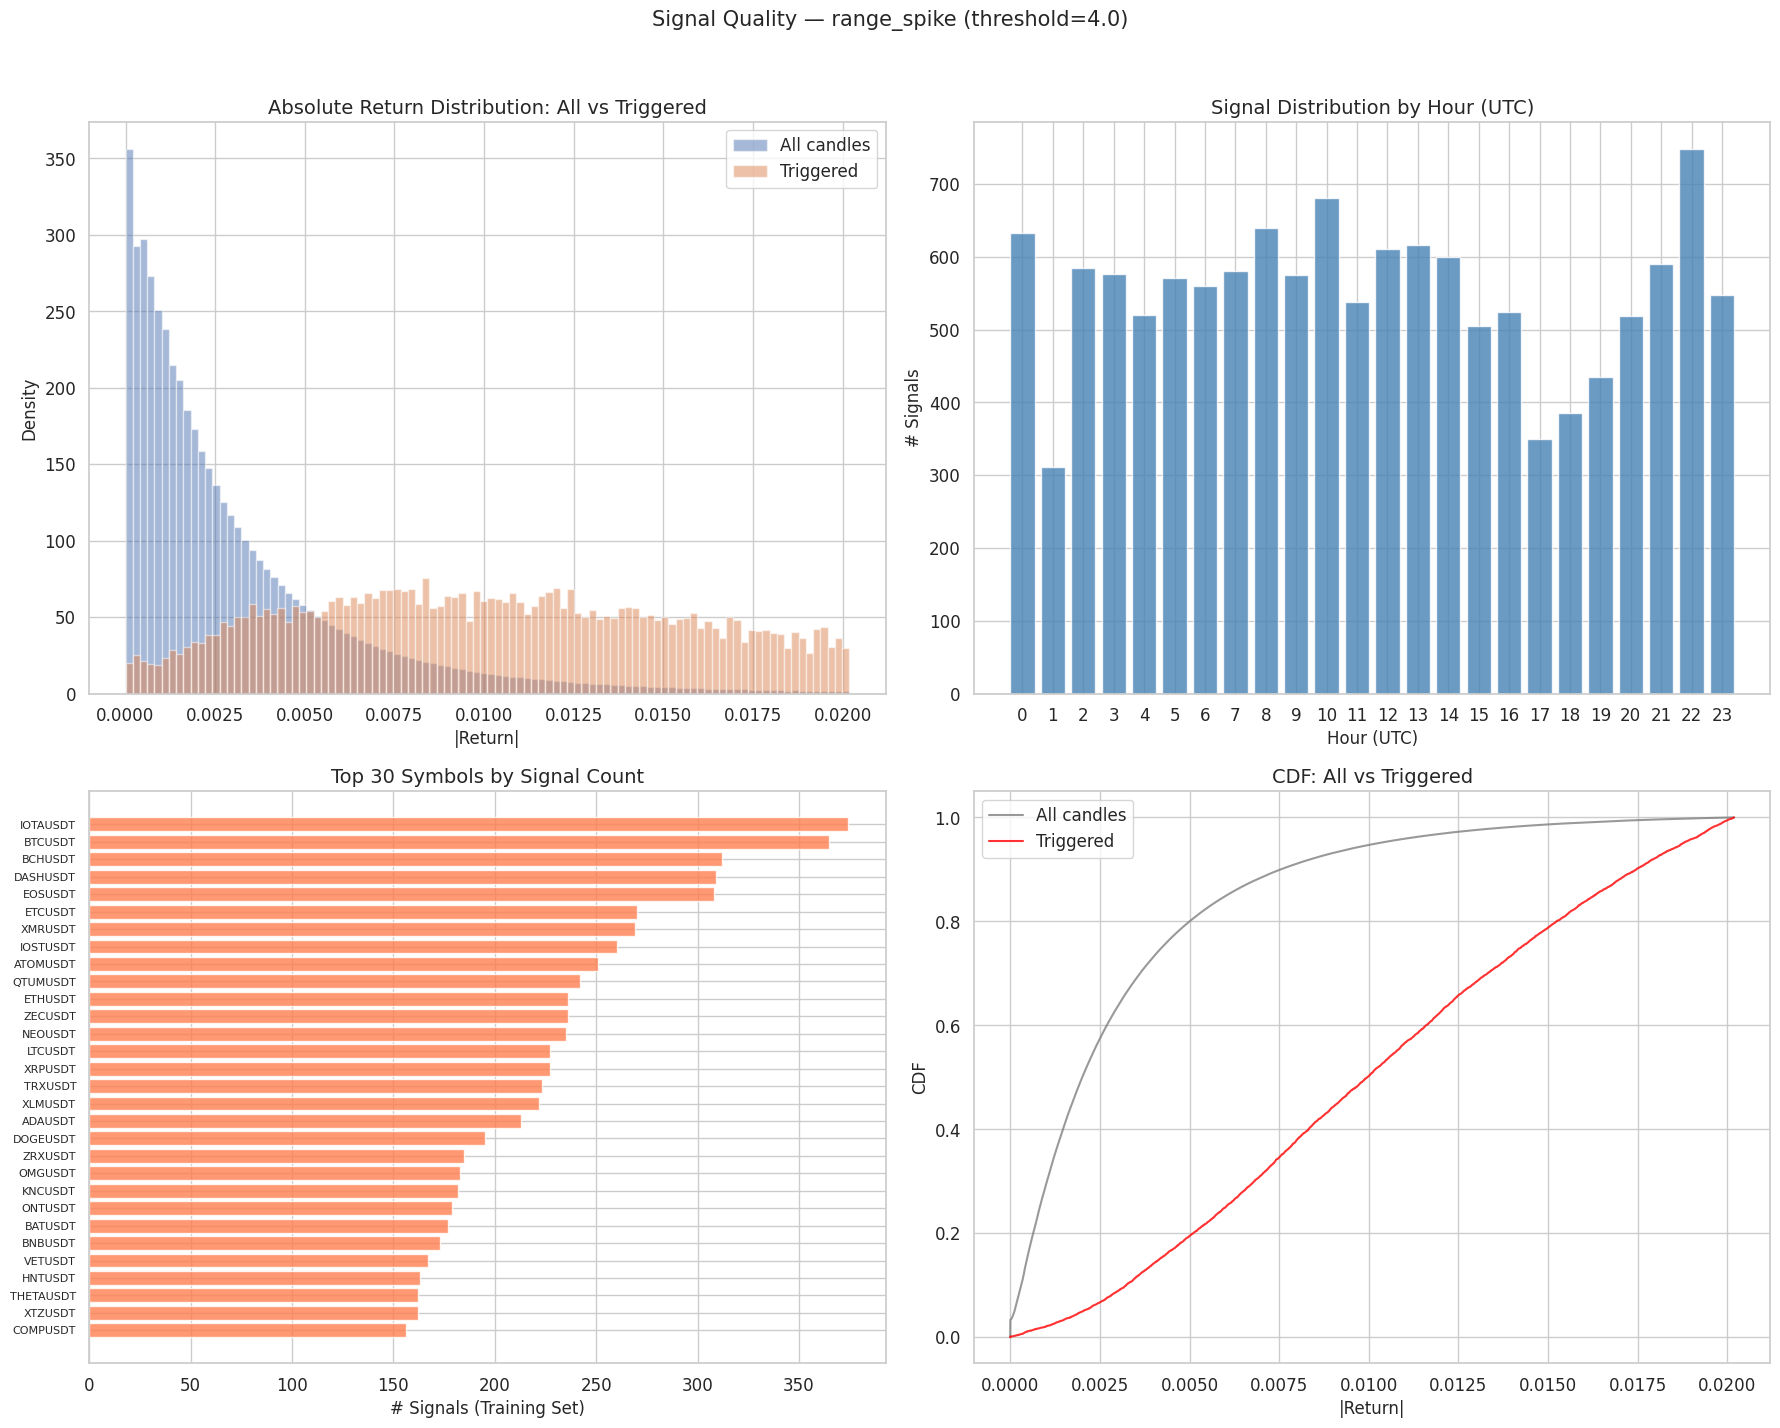

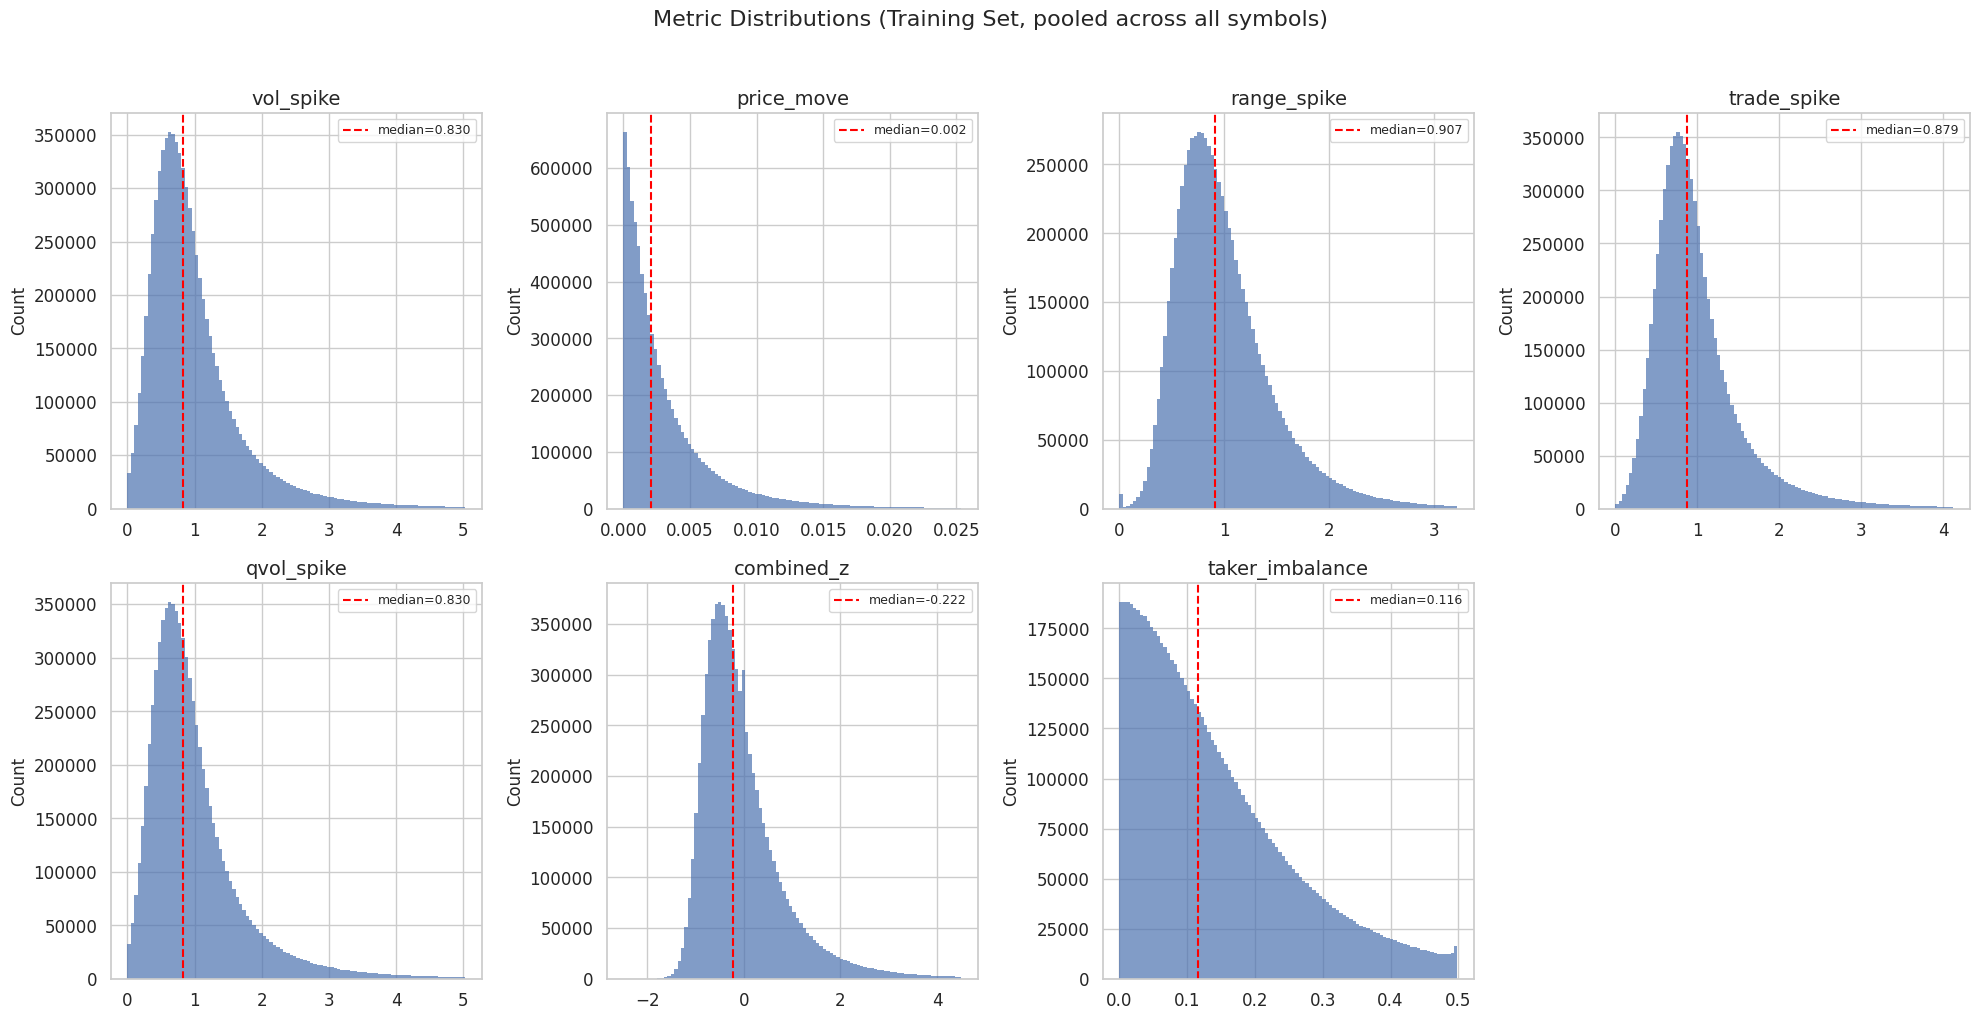

Saved threshold_metric_distributions.png


In [27]:
# --- Pool metrics from training set ---
pooled = {col: [] for col in METRIC_COLS}
for sym in symbols:
    for col in METRIC_COLS:
        vals = train_frames[sym][col].dropna().values
        pooled[col].append(vals)

pooled = {col: np.concatenate(arrs) for col, arrs in pooled.items()}

# --- Histograms ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
clip_percentile = 99.5  # clip display for readability

for i, col in enumerate(METRIC_COLS):
    ax = axes[i]
    data = pooled[col]
    clip_val = np.percentile(data, clip_percentile)
    ax.hist(data[data <= clip_val], bins=100, alpha=0.7, edgecolor="none")
    ax.set_title(col)
    ax.set_ylabel("Count")
    med = np.median(data)
    ax.axvline(med, color="red", ls="--", label=f"median={med:.3f}")
    ax.legend(fontsize=9)

# Hide unused subplot
axes[-1].set_visible(False)
fig.suptitle("Metric Distributions (Training Set, pooled across all symbols)", fontsize=16, y=1.02)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_metric_distributions.png")
plt.show()
print("Saved threshold_metric_distributions.png")

In [28]:
# --- Percentile table ---
percentiles = [50, 75, 90, 95, 97, 99, 99.5, 99.9]
pct_rows = []
for col in METRIC_COLS:
    row = {"metric": col}
    for p in percentiles:
        row[f"P{p}"] = round(np.percentile(pooled[col], p), 5)
    pct_rows.append(row)

pct_df = pd.DataFrame(pct_rows).set_index("metric")
pct_df.to_csv(OUTPUT_DIR / "threshold_metric_percentiles.csv")
print("Saved threshold_metric_percentiles.csv")
pct_df

Saved threshold_metric_percentiles.csv


,P50,P75,P90,P95,P97,P99,P99.5,P99.9
metric,,,,,,,,
vol_spike,0.82993,1.24507,1.88083,2.46074,2.94803,4.17091,5.03249,7.12237
price_move,0.00204,0.00433,0.00791,0.01105,0.01363,0.02019,0.02538,0.04326
range_spike,0.90696,1.22374,1.61984,1.93417,2.18256,2.78825,3.22492,4.40839
trade_spike,0.87907,1.20099,1.68943,2.13627,2.51080,3.45374,4.12734,5.83877
qvol_spike,0.83017,1.24528,1.88091,2.46057,2.94750,4.16797,5.02917,7.11969
combined_z,-0.22173,0.32330,1.08836,1.74245,2.27765,3.58374,4.50627,6.81514
taker_imbalance,0.11585,0.20894,0.31775,0.38775,0.42886,0.48483,0.49863,0.50000


## Section 4: Threshold Sweep — Monthly Signal Counts

In [29]:
def count_signals_per_month(frames: dict, metric: str, threshold: float) -> pd.Series:
    """Count total signals per month across all symbols for a given metric & threshold."""
    monthly_counts = defaultdict(int)
    for sym in frames:
        df = frames[sym]
        triggered = df[df[metric] >= threshold]
        months = triggered["open_time"].dt.to_period("M")
        for m, cnt in months.value_counts().items():
            monthly_counts[m] += cnt
    if not monthly_counts:
        return pd.Series(dtype=float)
    s = pd.Series(monthly_counts).sort_index()
    return s


# --- Define sweep ranges based on percentiles ---
sweep_ranges = {
    "vol_spike":        np.arange(1.5, 6.1, 0.25),
    "price_move":       np.arange(0.002, 0.021, 0.001),
    "range_spike":      np.arange(1.5, 6.1, 0.25),
    "trade_spike":      np.arange(1.5, 6.1, 0.25),
    "qvol_spike":       np.arange(1.5, 6.1, 0.25),
    "combined_z":       np.arange(0.5, 4.1, 0.25),
    "taker_imbalance":  np.arange(0.02, 0.21, 0.01),
}

# --- Sweep all metrics ---
sweep_results = {}  # metric -> {threshold: Series of monthly counts}
best_thresholds = {}

for metric in tqdm(METRIC_COLS, desc="Sweeping metrics"):
    thresholds = sweep_ranges[metric]
    metric_results = {}
    best_diff = float("inf")
    best_t = thresholds[0]

    for t in thresholds:
        monthly = count_signals_per_month(train_frames, metric, t)
        metric_results[round(t, 4)] = monthly
        if len(monthly) > 0:
            avg = monthly.mean()
            diff = abs(avg - TARGET_SIGNALS_MONTH)
            if diff < best_diff:
                best_diff = diff
                best_t = round(t, 4)

    sweep_results[metric] = metric_results
    best_thresholds[metric] = best_t

print("\nBest thresholds (closest to 600 signals/month on training set):")
for m, t in best_thresholds.items():
    monthly = sweep_results[m][t]
    avg = monthly.mean() if len(monthly) > 0 else 0
    print(f"  {m:20s} -> threshold={t:<8} avg_signals/month={avg:.0f}")

Sweeping metrics:   0%|          | 0/7 [00:00<?, ?it/s]


Best thresholds (closest to 600 signals/month on training set):
  vol_spike            -> threshold=6.0      avg_signals/month=768
  price_move           -> threshold=0.021    avg_signals/month=2909
  range_spike          -> threshold=4.0      avg_signals/month=550
  trade_spike          -> threshold=5.25     avg_signals/month=560
  qvol_spike           -> threshold=6.0      avg_signals/month=764
  combined_z           -> threshold=4.0      avg_signals/month=2372
  taker_imbalance      -> threshold=0.2      avg_signals/month=87150


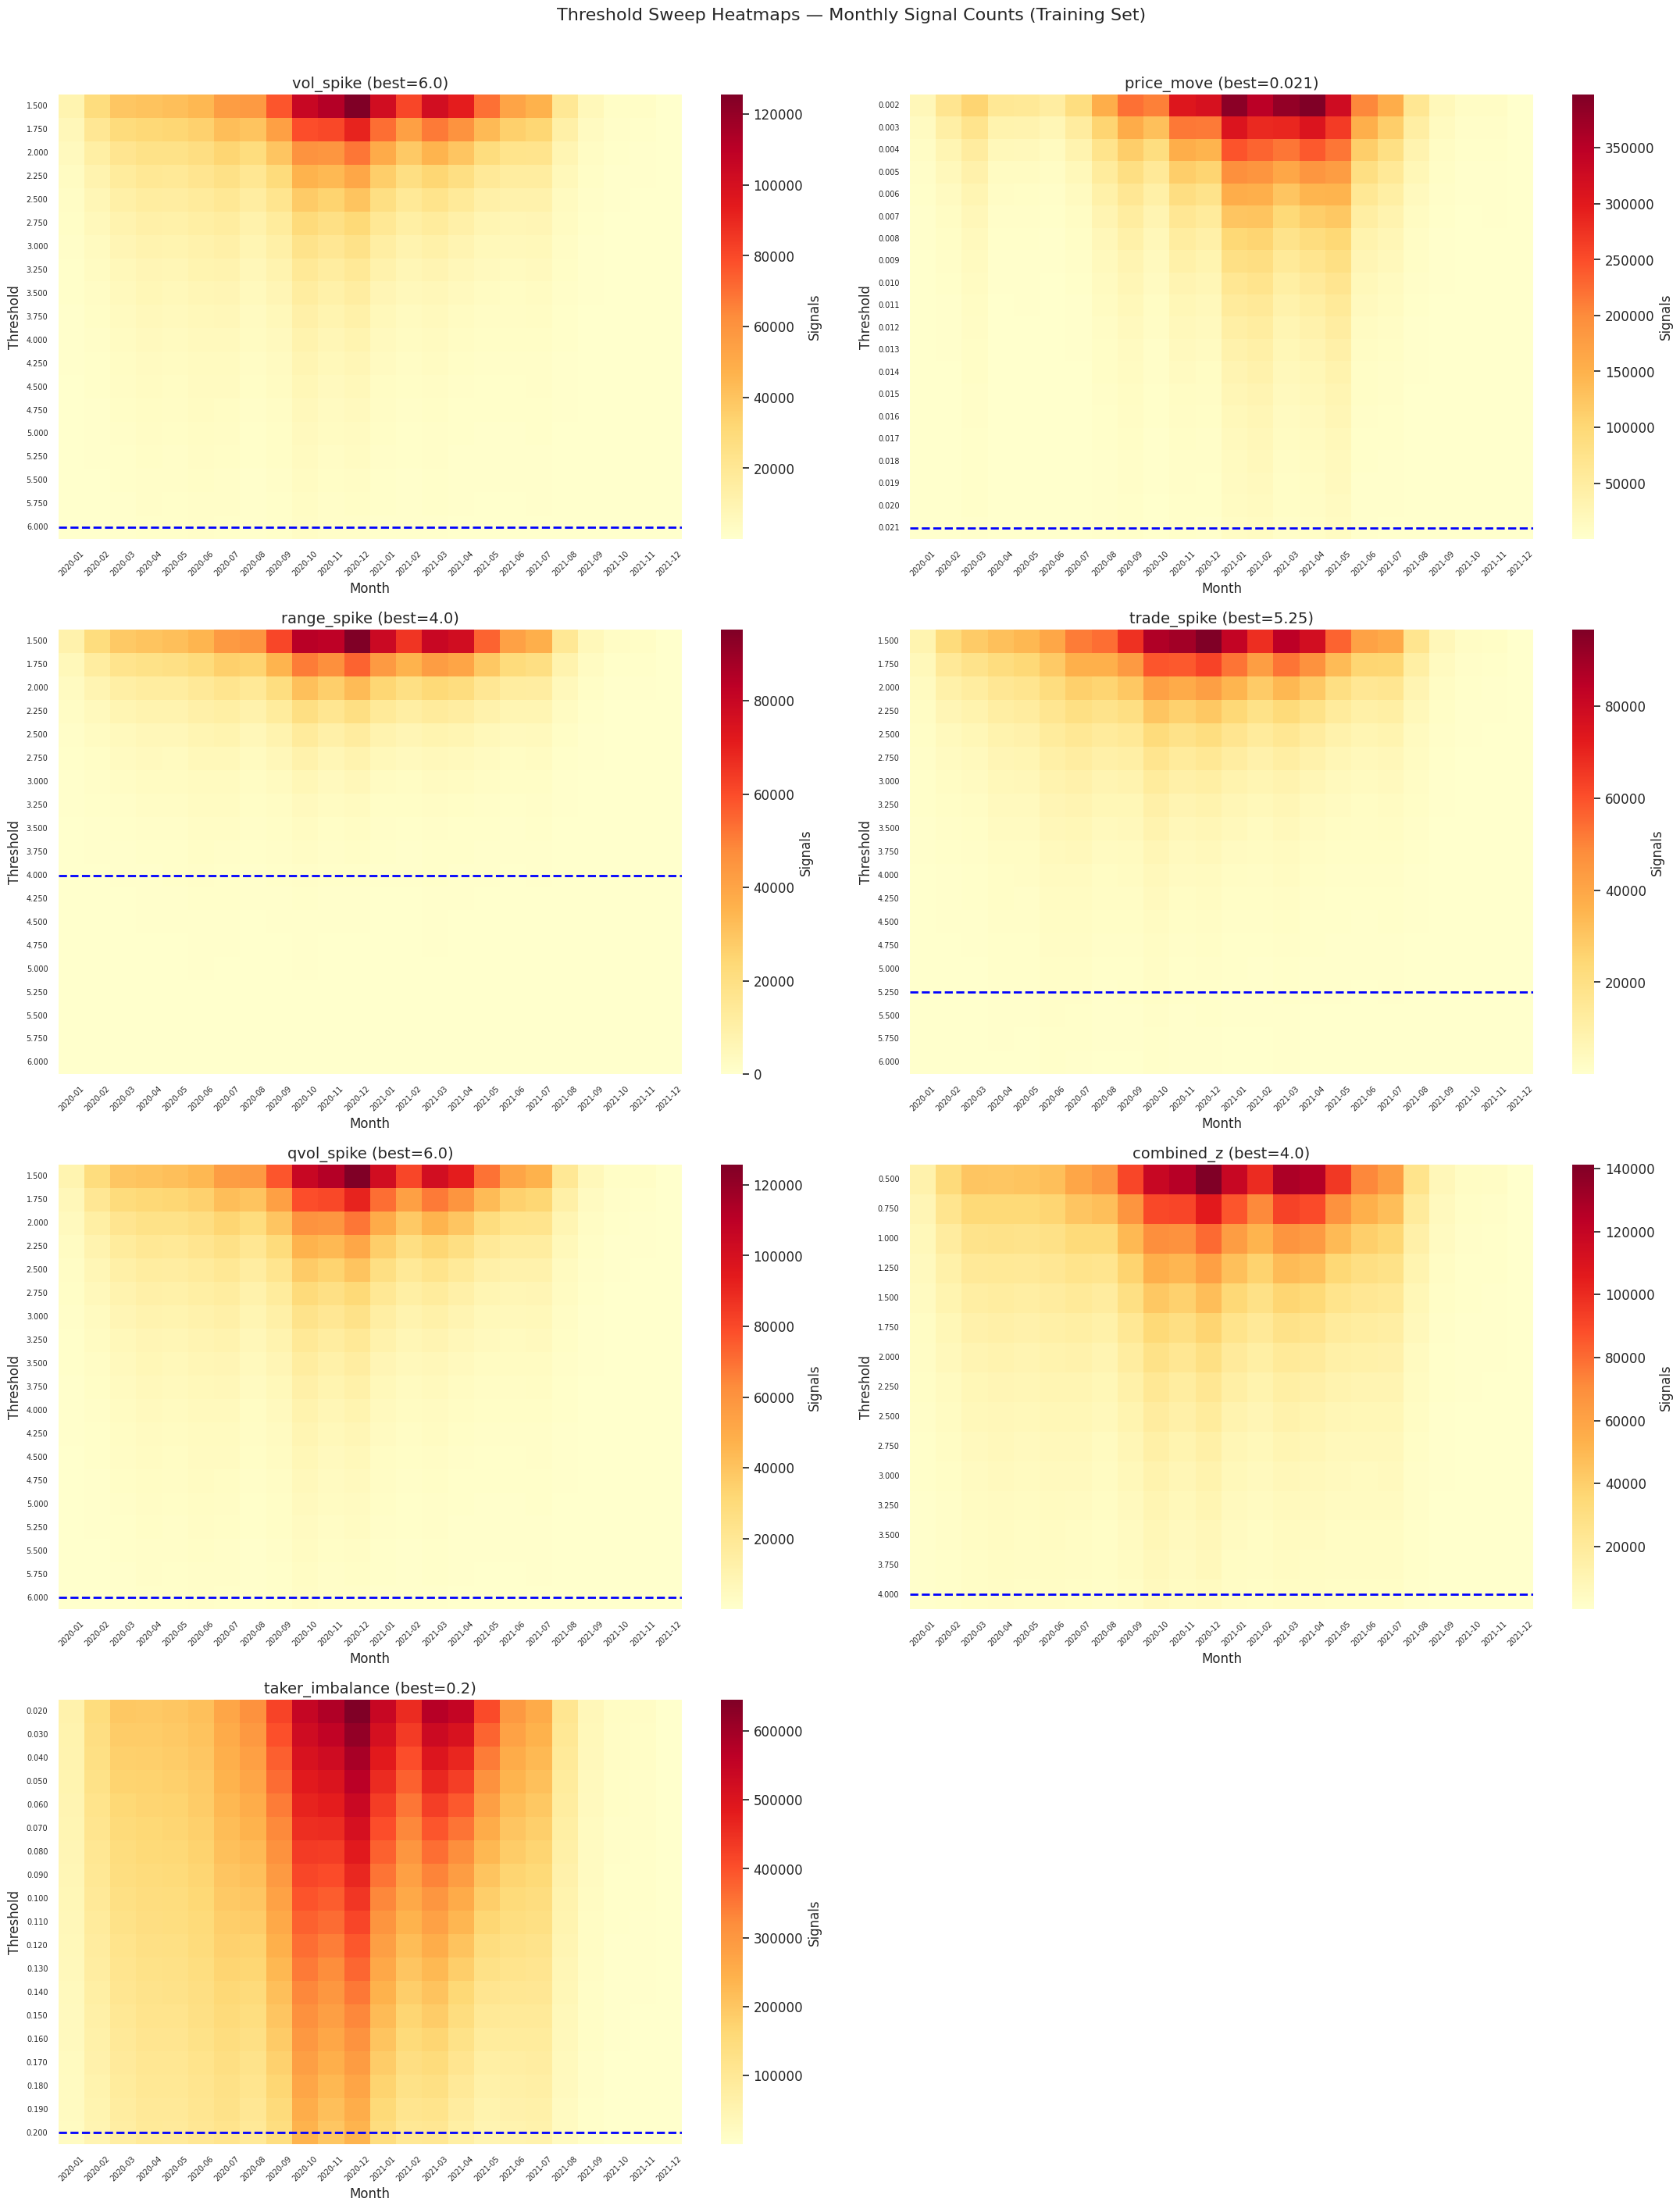

Saved threshold_sweep_heatmaps.png


In [30]:
# --- Heatmaps: x=month, y=threshold, color=signal count ---
fig, axes = plt.subplots(4, 2, figsize=(22, 28))
axes = axes.flatten()

for i, metric in enumerate(METRIC_COLS):
    ax = axes[i]
    results = sweep_results[metric]

    # Build matrix
    all_months = sorted(set().union(*(s.index for s in results.values() if len(s) > 0)))
    thresholds_sorted = sorted(results.keys())
    matrix = np.zeros((len(thresholds_sorted), len(all_months)))
    for ri, t in enumerate(thresholds_sorted):
        s = results[t]
        for ci, m in enumerate(all_months):
            matrix[ri, ci] = s.get(m, 0)

    sns.heatmap(
        matrix, ax=ax, cmap="YlOrRd",
        xticklabels=[str(m) for m in all_months],
        yticklabels=[f"{t:.3f}" for t in thresholds_sorted],
        cbar_kws={"label": "Signals"}
    )
    ax.set_title(f"{metric} (best={best_thresholds[metric]})")
    ax.set_xlabel("Month")
    ax.set_ylabel("Threshold")
    # Highlight best threshold row
    best_idx = thresholds_sorted.index(best_thresholds[metric])
    ax.axhline(y=best_idx + 0.5, color="blue", linewidth=2, linestyle="--")
    ax.tick_params(axis="x", rotation=45, labelsize=7)
    ax.tick_params(axis="y", labelsize=7)

axes[-1].set_visible(False)
fig.suptitle("Threshold Sweep Heatmaps — Monthly Signal Counts (Training Set)", fontsize=16, y=1.01)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_sweep_heatmaps.png")
plt.show()
print("Saved threshold_sweep_heatmaps.png")

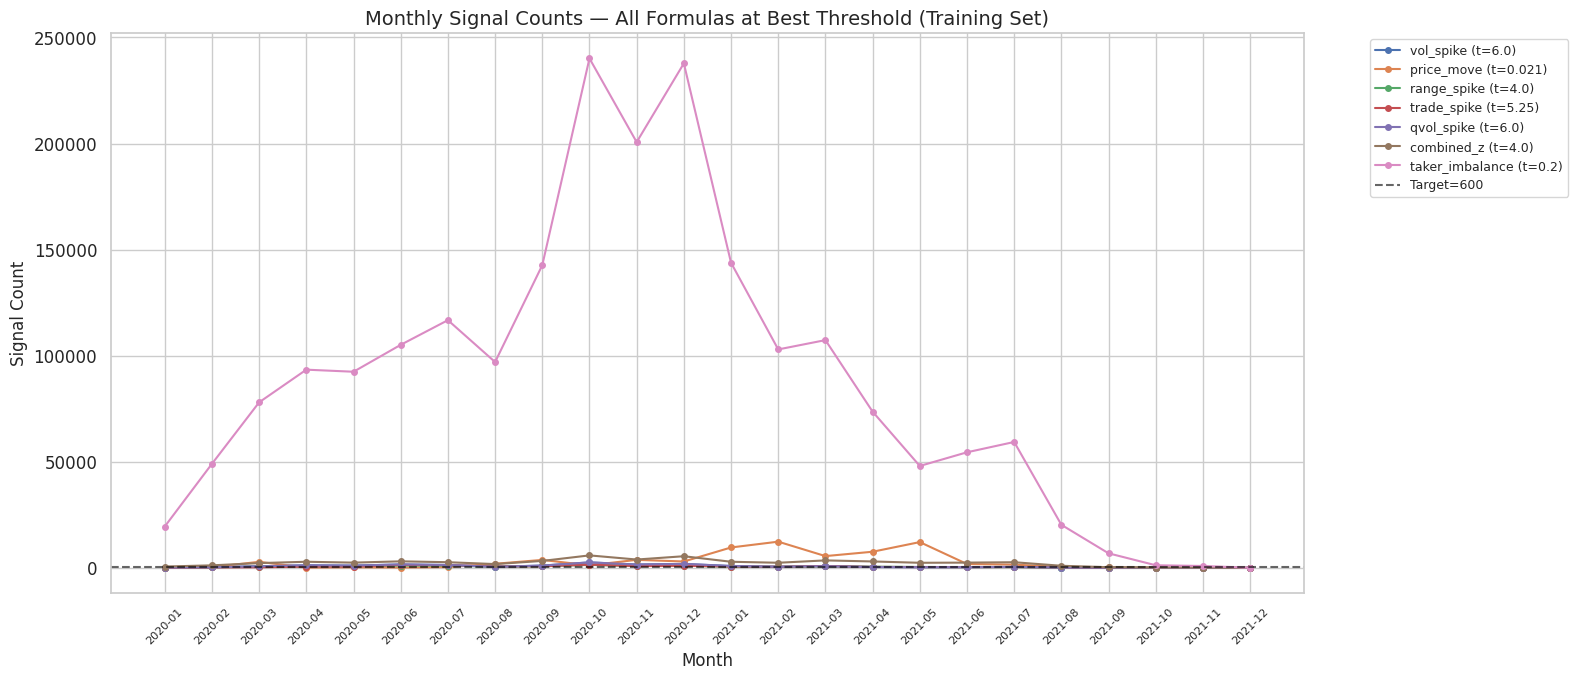

Saved threshold_monthly_signals_train.png


In [31]:
# --- Line plot: all 7 formulas at their best threshold, monthly signals ---
fig, ax = plt.subplots(figsize=(16, 7))

for metric in METRIC_COLS:
    t = best_thresholds[metric]
    monthly = sweep_results[metric][t]
    if len(monthly) == 0:
        continue
    months_str = [str(m) for m in monthly.index]
    ax.plot(months_str, monthly.values, marker="o", markersize=4, label=f"{metric} (t={t})")

ax.axhline(TARGET_SIGNALS_MONTH, color="black", ls="--", alpha=0.6, label=f"Target={TARGET_SIGNALS_MONTH}")
ax.set_xlabel("Month")
ax.set_ylabel("Signal Count")
ax.set_title("Monthly Signal Counts — All Formulas at Best Threshold (Training Set)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_monthly_signals_train.png")
plt.show()
print("Saved threshold_monthly_signals_train.png")

## Section 5: Validation on Held-Out Data

In [32]:
# --- Apply best thresholds to validation set (no recalibration) ---
comparison_rows = []

for metric in METRIC_COLS:
    t = best_thresholds[metric]

    train_monthly = count_signals_per_month(train_frames, metric, t)
    val_monthly = count_signals_per_month(val_frames, metric, t)

    train_avg = train_monthly.mean() if len(train_monthly) > 0 else 0
    val_avg = val_monthly.mean() if len(val_monthly) > 0 else 0
    train_cv = (train_monthly.std() / train_avg * 100) if train_avg > 0 else np.nan
    val_cv = (val_monthly.std() / val_avg * 100) if val_avg > 0 else np.nan
    drift_pct = ((val_avg - train_avg) / train_avg * 100) if train_avg > 0 else np.nan

    comparison_rows.append({
        "metric": metric,
        "threshold": t,
        "train_avg": round(train_avg, 1),
        "val_avg": round(val_avg, 1),
        "drift_pct": round(drift_pct, 1),
        "train_cv_pct": round(train_cv, 1),
        "val_cv_pct": round(val_cv, 1),
    })

comp_df = pd.DataFrame(comparison_rows).set_index("metric")
comp_df.to_csv(OUTPUT_DIR / "threshold_train_val_comparison.csv")
print("Saved threshold_train_val_comparison.csv")
comp_df

Saved threshold_train_val_comparison.csv


,threshold,train_avg,val_avg,drift_pct,train_cv_pct,val_cv_pct
metric,,,,,,
vol_spike,6.000,767.5,423.7,-44.8,89.3,114.4
price_move,0.021,2909.0,2311.1,-20.6,131.7,126.8
range_spike,4.000,549.9,447.0,-18.7,70.9,114.5
trade_spike,5.250,559.5,319.8,-42.8,78.7,109.3
qvol_spike,6.000,764.4,425.8,-44.3,89.1,114.3
combined_z,4.000,2371.9,3671.1,54.8,65.1,105.8
taker_imbalance,0.200,87149.7,40088.1,-54.0,79.4,108.2


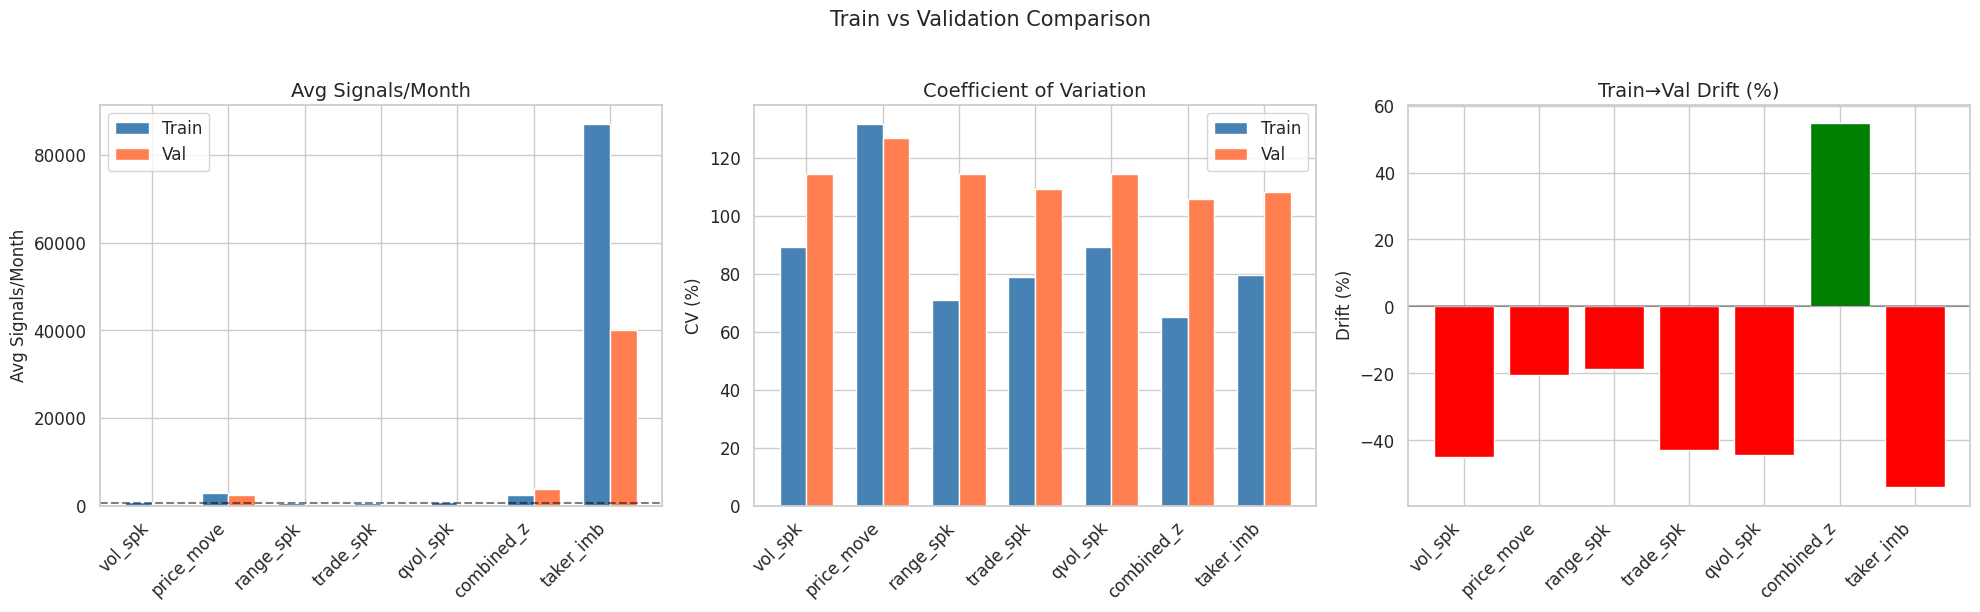

Saved threshold_train_val_comparison.png


In [33]:
# --- Side-by-side bar charts: train vs validation ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

metrics_short = [m.replace("_spike", "_spk").replace("_imbalance", "_imb") for m in comp_df.index]
x = np.arange(len(comp_df))
w = 0.35

# Avg signals
ax = axes[0]
ax.bar(x - w/2, comp_df["train_avg"], w, label="Train", color="steelblue")
ax.bar(x + w/2, comp_df["val_avg"], w, label="Val", color="coral")
ax.axhline(TARGET_SIGNALS_MONTH, color="black", ls="--", alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(metrics_short, rotation=45, ha="right")
ax.set_ylabel("Avg Signals/Month")
ax.set_title("Avg Signals/Month")
ax.legend()

# CV
ax = axes[1]
ax.bar(x - w/2, comp_df["train_cv_pct"], w, label="Train", color="steelblue")
ax.bar(x + w/2, comp_df["val_cv_pct"], w, label="Val", color="coral")
ax.set_xticks(x)
ax.set_xticklabels(metrics_short, rotation=45, ha="right")
ax.set_ylabel("CV (%)")
ax.set_title("Coefficient of Variation")
ax.legend()

# Drift
ax = axes[2]
colors = ["green" if d >= 0 else "red" for d in comp_df["drift_pct"]]
ax.bar(x, comp_df["drift_pct"], color=colors)
ax.set_xticks(x)
ax.set_xticklabels(metrics_short, rotation=45, ha="right")
ax.set_ylabel("Drift (%)")
ax.set_title("Train→Val Drift (%)")
ax.axhline(0, color="black", ls="-", alpha=0.3)

fig.suptitle("Train vs Validation Comparison", fontsize=15, y=1.02)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_train_val_comparison.png")
plt.show()
print("Saved threshold_train_val_comparison.png")

## Section 6: Formula Ranking

In [34]:
# --- Rank formulas on: stability (low CV), generalization (low drift), target proximity ---
ranking_rows = []
for _, row in comp_df.iterrows():
    avg_cv = (row["train_cv_pct"] + row["val_cv_pct"]) / 2
    abs_drift = abs(row["drift_pct"])
    target_err = abs(row["train_avg"] - TARGET_SIGNALS_MONTH) / TARGET_SIGNALS_MONTH * 100

    ranking_rows.append({
        "metric": row.name if hasattr(row, "name") else row["metric"],
        "avg_cv": round(avg_cv, 1),
        "abs_drift": round(abs_drift, 1),
        "target_err_pct": round(target_err, 1),
    })

rank_df = pd.DataFrame(ranking_rows).set_index("metric")

# Normalize each column to [0, 1] (lower = better) for scoring
for col in ["avg_cv", "abs_drift", "target_err_pct"]:
    cmin, cmax = rank_df[col].min(), rank_df[col].max()
    rank_df[f"{col}_norm"] = (rank_df[col] - cmin) / (cmax - cmin + 1e-9)

# Weighted composite score (lower = better): 40% stability, 30% drift, 30% target
rank_df["composite_score"] = (
    0.40 * rank_df["avg_cv_norm"] +
    0.30 * rank_df["abs_drift_norm"] +
    0.30 * rank_df["target_err_pct_norm"]
)
rank_df = rank_df.sort_values("composite_score")
rank_df["rank"] = range(1, len(rank_df) + 1)

top_formula = rank_df.index[0]
print(f"Top formula: {top_formula} (composite score = {rank_df['composite_score'].iloc[0]:.3f})")

rank_df[["avg_cv", "abs_drift", "target_err_pct", "composite_score", "rank"]].to_csv(
    OUTPUT_DIR / "threshold_formula_ranking.csv"
)
print("Saved threshold_formula_ranking.csv")
rank_df[["avg_cv", "abs_drift", "target_err_pct", "composite_score", "rank"]]

Top formula: range_spike (composite score = 0.067)
Saved threshold_formula_ranking.csv


,avg_cv,abs_drift,target_err_pct,composite_score,rank
metric,,,,,
range_spike,92.7,18.7,8.4,0.066700,1
trade_spike,94.0,42.8,6.8,0.278816,2
combined_z,85.4,54.8,295.3,0.306003,3
qvol_spike,101.7,44.3,27.4,0.362029,4
vol_spike,101.8,44.8,27.9,0.367108,5
price_move,129.2,20.6,384.8,0.423655,6
taker_imbalance,93.8,54.0,14425.0,0.670064,7


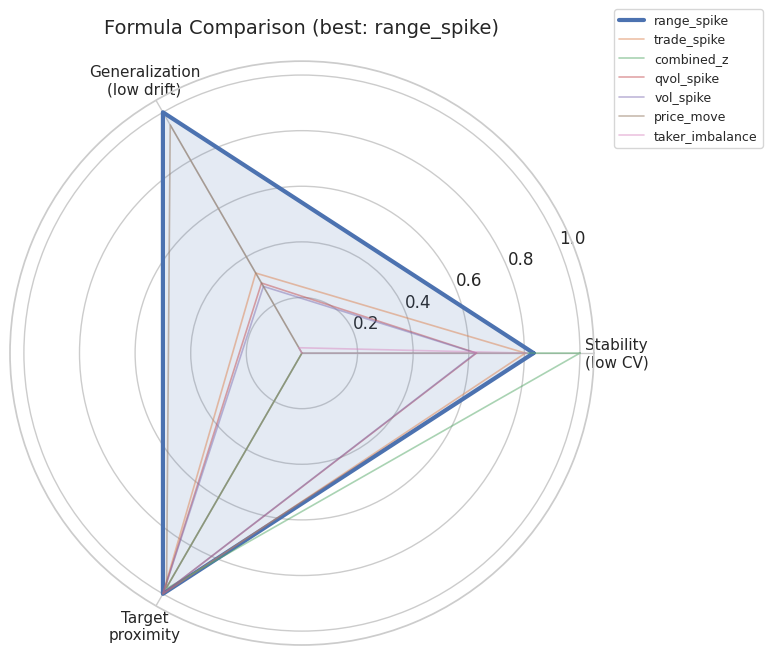

Saved threshold_formula_radar.png


In [35]:
# --- Radar chart comparing all formulas ---
categories = ["Stability\n(low CV)", "Generalization\n(low drift)", "Target\nproximity"]
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for metric in rank_df.index:
    # Invert scores: 1 - norm so higher = better
    values = [
        1 - rank_df.loc[metric, "avg_cv_norm"],
        1 - rank_df.loc[metric, "abs_drift_norm"],
        1 - rank_df.loc[metric, "target_err_pct_norm"],
    ]
    values += values[:1]
    lw = 3 if metric == top_formula else 1.2
    alpha = 1.0 if metric == top_formula else 0.5
    ax.plot(angles, values, linewidth=lw, alpha=alpha, label=metric)
    if metric == top_formula:
        ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1.05)
ax.set_title(f"Formula Comparison (best: {top_formula})", fontsize=14, pad=20)
ax.legend(bbox_to_anchor=(1.3, 1.1), fontsize=9)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_formula_radar.png")
plt.show()
print("Saved threshold_formula_radar.png")

## Section 7: Static vs Dynamic Thresholds

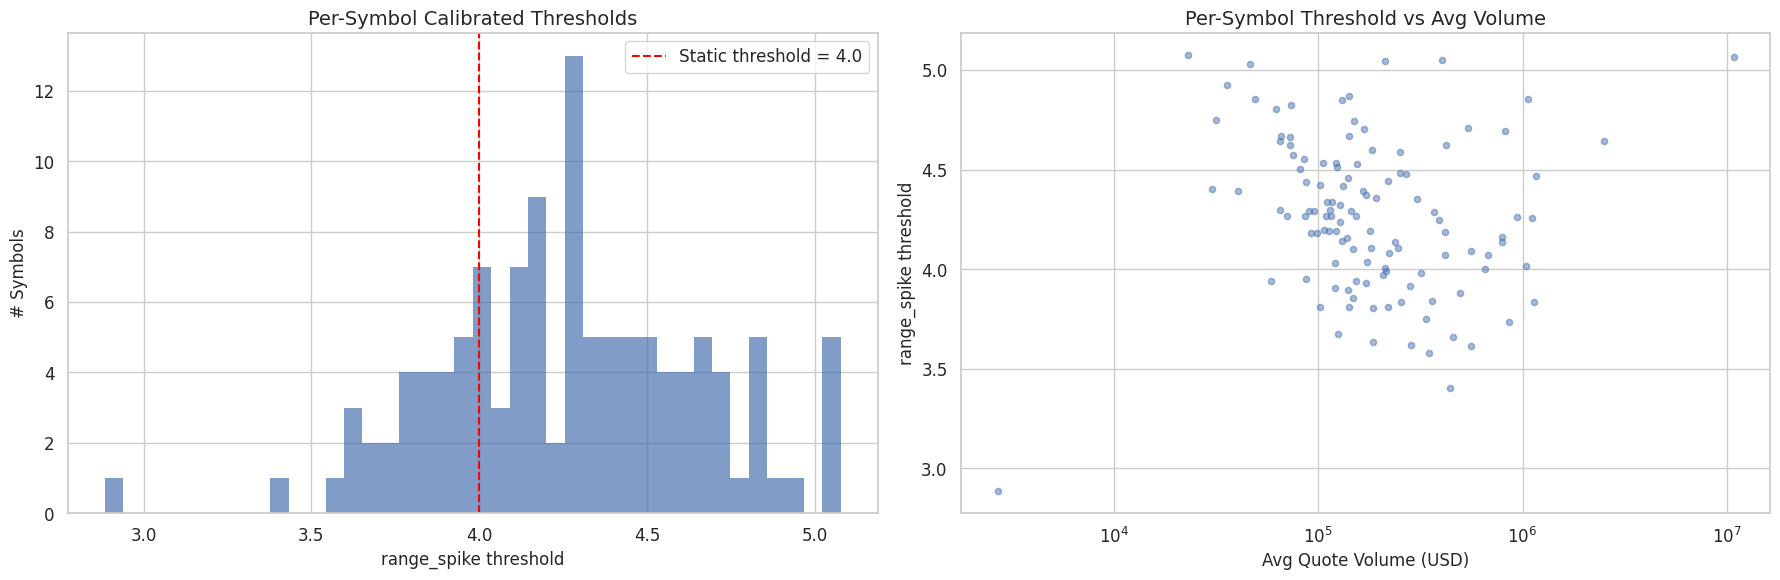

Saved threshold_persymbol.png


In [36]:
# --- Per-symbol calibration: find per-symbol threshold for the top formula ---
static_t = best_thresholds[top_formula]

per_symbol_thresholds = {}
per_symbol_avg_volume = {}
for sym in symbols:
    df = train_frames[sym]
    vals = df[top_formula].dropna()
    per_symbol_avg_volume[sym] = df["quote_volume"].mean()
    if len(vals) == 0:
        per_symbol_thresholds[sym] = static_t
        continue

    # Find threshold that gives ~(600 / n_symbols) signals/month for this symbol
    n_months = max(1, (df["open_time"].iloc[-1] - df["open_time"].iloc[0]).days / 30)
    target_per_sym = TARGET_SIGNALS_MONTH / len(symbols) * n_months

    # Binary search on percentile
    best_pt, best_diff = static_t, float("inf")
    for pct in np.arange(90, 99.95, 0.1):
        t_cand = np.percentile(vals, pct)
        n_signals = (vals >= t_cand).sum()
        diff = abs(n_signals - target_per_sym)
        if diff < best_diff:
            best_diff = diff
            best_pt = t_cand
    per_symbol_thresholds[sym] = best_pt

psym_series = pd.Series(per_symbol_thresholds)
pvol_series = pd.Series(per_symbol_avg_volume)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Distribution of per-symbol thresholds
ax = axes[0]
ax.hist(psym_series.values, bins=40, alpha=0.7, edgecolor="none")
ax.axvline(static_t, color="red", ls="--", label=f"Static threshold = {static_t}")
ax.set_xlabel(f"{top_formula} threshold")
ax.set_ylabel("# Symbols")
ax.set_title("Per-Symbol Calibrated Thresholds")
ax.legend()

# Scatter: per-symbol threshold vs avg volume
ax = axes[1]
ax.scatter(pvol_series.values, psym_series.values, alpha=0.5, s=20)
ax.set_xlabel("Avg Quote Volume (USD)")
ax.set_ylabel(f"{top_formula} threshold")
ax.set_title("Per-Symbol Threshold vs Avg Volume")
ax.set_xscale("log")

plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_persymbol.png")
plt.show()
print("Saved threshold_persymbol.png")

In [37]:
# --- Regime-adaptive threshold ---
# Scale threshold by (rolling_30d_vol / avg_vol)^0.5
# During high-vol periods threshold rises, during calm periods it falls
ADAPTIVE_ALPHA = 0.5
REGIME_WINDOW = 30 * 24 * 12  # 30 days of 5m candles = 8640


def count_adaptive_signals_per_month(frames, metric, base_threshold, alpha=ADAPTIVE_ALPHA):
    """Count signals using regime-adaptive threshold."""
    monthly_counts = defaultdict(int)
    for sym in frames:
        df = frames[sym]
        # Rolling 30d quote volume
        rolling_vol = df["quote_volume"].rolling(REGIME_WINDOW, min_periods=ROLLING_WINDOW).mean()
        avg_vol = df["quote_volume"].expanding(min_periods=ROLLING_WINDOW).mean()
        regime_factor = (rolling_vol / avg_vol.replace(0, np.nan)) ** alpha
        adaptive_threshold = base_threshold * regime_factor

        triggered = df[df[metric] >= adaptive_threshold]
        months = triggered["open_time"].dt.to_period("M")
        for m, cnt in months.value_counts().items():
            monthly_counts[m] += cnt
    return pd.Series(monthly_counts).sort_index() if monthly_counts else pd.Series(dtype=float)


# Compare static vs adaptive on train and val
strategies = {
    "static": {
        "train": count_signals_per_month(train_frames, top_formula, static_t),
        "val": count_signals_per_month(val_frames, top_formula, static_t),
    },
    "adaptive": {
        "train": count_adaptive_signals_per_month(train_frames, top_formula, static_t),
        "val": count_adaptive_signals_per_month(val_frames, top_formula, static_t),
    },
}

strategy_rows = []
for name, data in strategies.items():
    tr, va = data["train"], data["val"]
    tr_avg = tr.mean() if len(tr) > 0 else 0
    va_avg = va.mean() if len(va) > 0 else 0
    tr_cv = (tr.std() / tr_avg * 100) if tr_avg > 0 else np.nan
    va_cv = (va.std() / va_avg * 100) if va_avg > 0 else np.nan
    drift = ((va_avg - tr_avg) / tr_avg * 100) if tr_avg > 0 else np.nan
    strategy_rows.append({
        "strategy": name,
        "train_avg": round(tr_avg, 1),
        "val_avg": round(va_avg, 1),
        "drift_pct": round(drift, 1),
        "train_cv_pct": round(tr_cv, 1),
        "val_cv_pct": round(va_cv, 1),
    })

strat_df = pd.DataFrame(strategy_rows).set_index("strategy")
print(f"Formula: {top_formula}, base threshold: {static_t}")
strat_df

Formula: range_spike, base threshold: 4.0


,train_avg,val_avg,drift_pct,train_cv_pct,val_cv_pct
strategy,,,,,
static,549.9,447.0,-18.7,70.9,114.5
adaptive,1030.0,995.0,-3.4,109.2,133.5


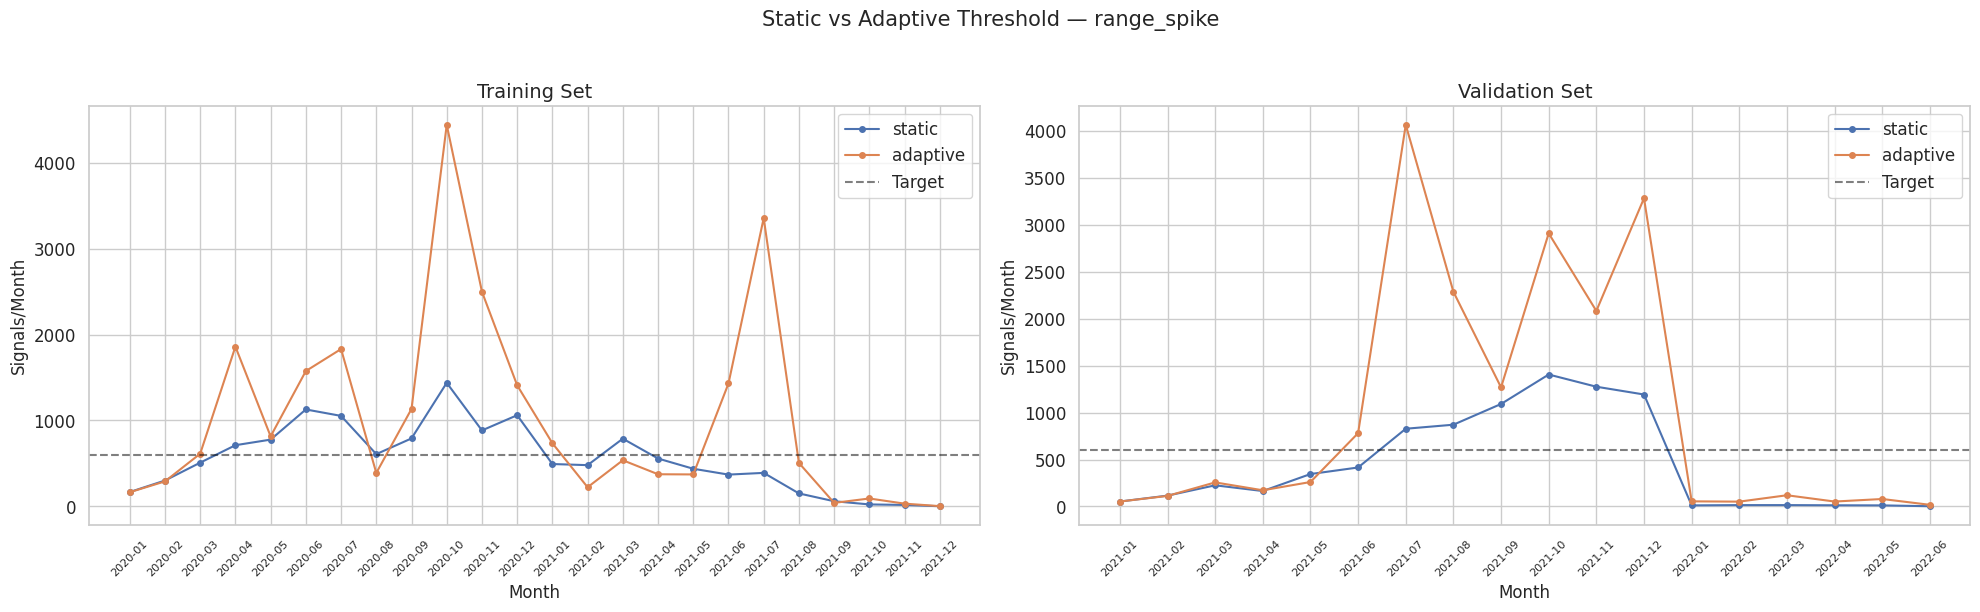

Saved threshold_static_vs_adaptive.png


In [38]:
# --- Plot static vs adaptive monthly signals ---
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for idx, (split_name, split_label) in enumerate([("train", "Training"), ("val", "Validation")]):
    ax = axes[idx]
    for name in ["static", "adaptive"]:
        s = strategies[name][split_name]
        if len(s) == 0:
            continue
        months_str = [str(m) for m in s.index]
        ax.plot(months_str, s.values, marker="o", markersize=4, label=name)
    ax.axhline(TARGET_SIGNALS_MONTH, color="black", ls="--", alpha=0.5, label="Target")
    ax.set_title(f"{split_label} Set")
    ax.set_xlabel("Month")
    ax.set_ylabel("Signals/Month")
    ax.legend()
    ax.tick_params(axis="x", rotation=45, labelsize=8)

fig.suptitle(f"Static vs Adaptive Threshold — {top_formula}", fontsize=15, y=1.02)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_static_vs_adaptive.png")
plt.show()
print("Saved threshold_static_vs_adaptive.png")

## Section 8: Signal Quality Sanity Check

In [39]:
# --- Collect triggered vs all candle returns, hour distribution, per-symbol spread ---
all_returns = []
triggered_returns = []
triggered_hours = []
per_symbol_signal_count = defaultdict(int)

for sym in tqdm(symbols, desc="Collecting signal quality data"):
    df = train_frames[sym].copy()
    df["abs_return"] = ((df["close"] - df["open"]) / df["open"].replace(0, np.nan)).abs()

    mask = df[top_formula] >= static_t
    all_returns.append(df["abs_return"].dropna().values)
    triggered_returns.append(df.loc[mask, "abs_return"].dropna().values)
    triggered_hours.append(df.loc[mask, "open_time"].dt.hour.values)
    per_symbol_signal_count[sym] = mask.sum()

all_returns = np.concatenate(all_returns)
triggered_returns = np.concatenate(triggered_returns)
triggered_hours = np.concatenate(triggered_hours)

print(f"All candles: {len(all_returns):,} | Triggered: {len(triggered_returns):,}")
print(f"Mean abs return — all: {all_returns.mean()*100:.4f}%  triggered: {triggered_returns.mean()*100:.4f}%")
print(f"Ratio: {triggered_returns.mean() / all_returns.mean():.1f}x")

All candles: 7,839,271 | Triggered: 13,198
Mean abs return — all: 0.3405%  triggered: 2.2754%
Ratio: 6.7x


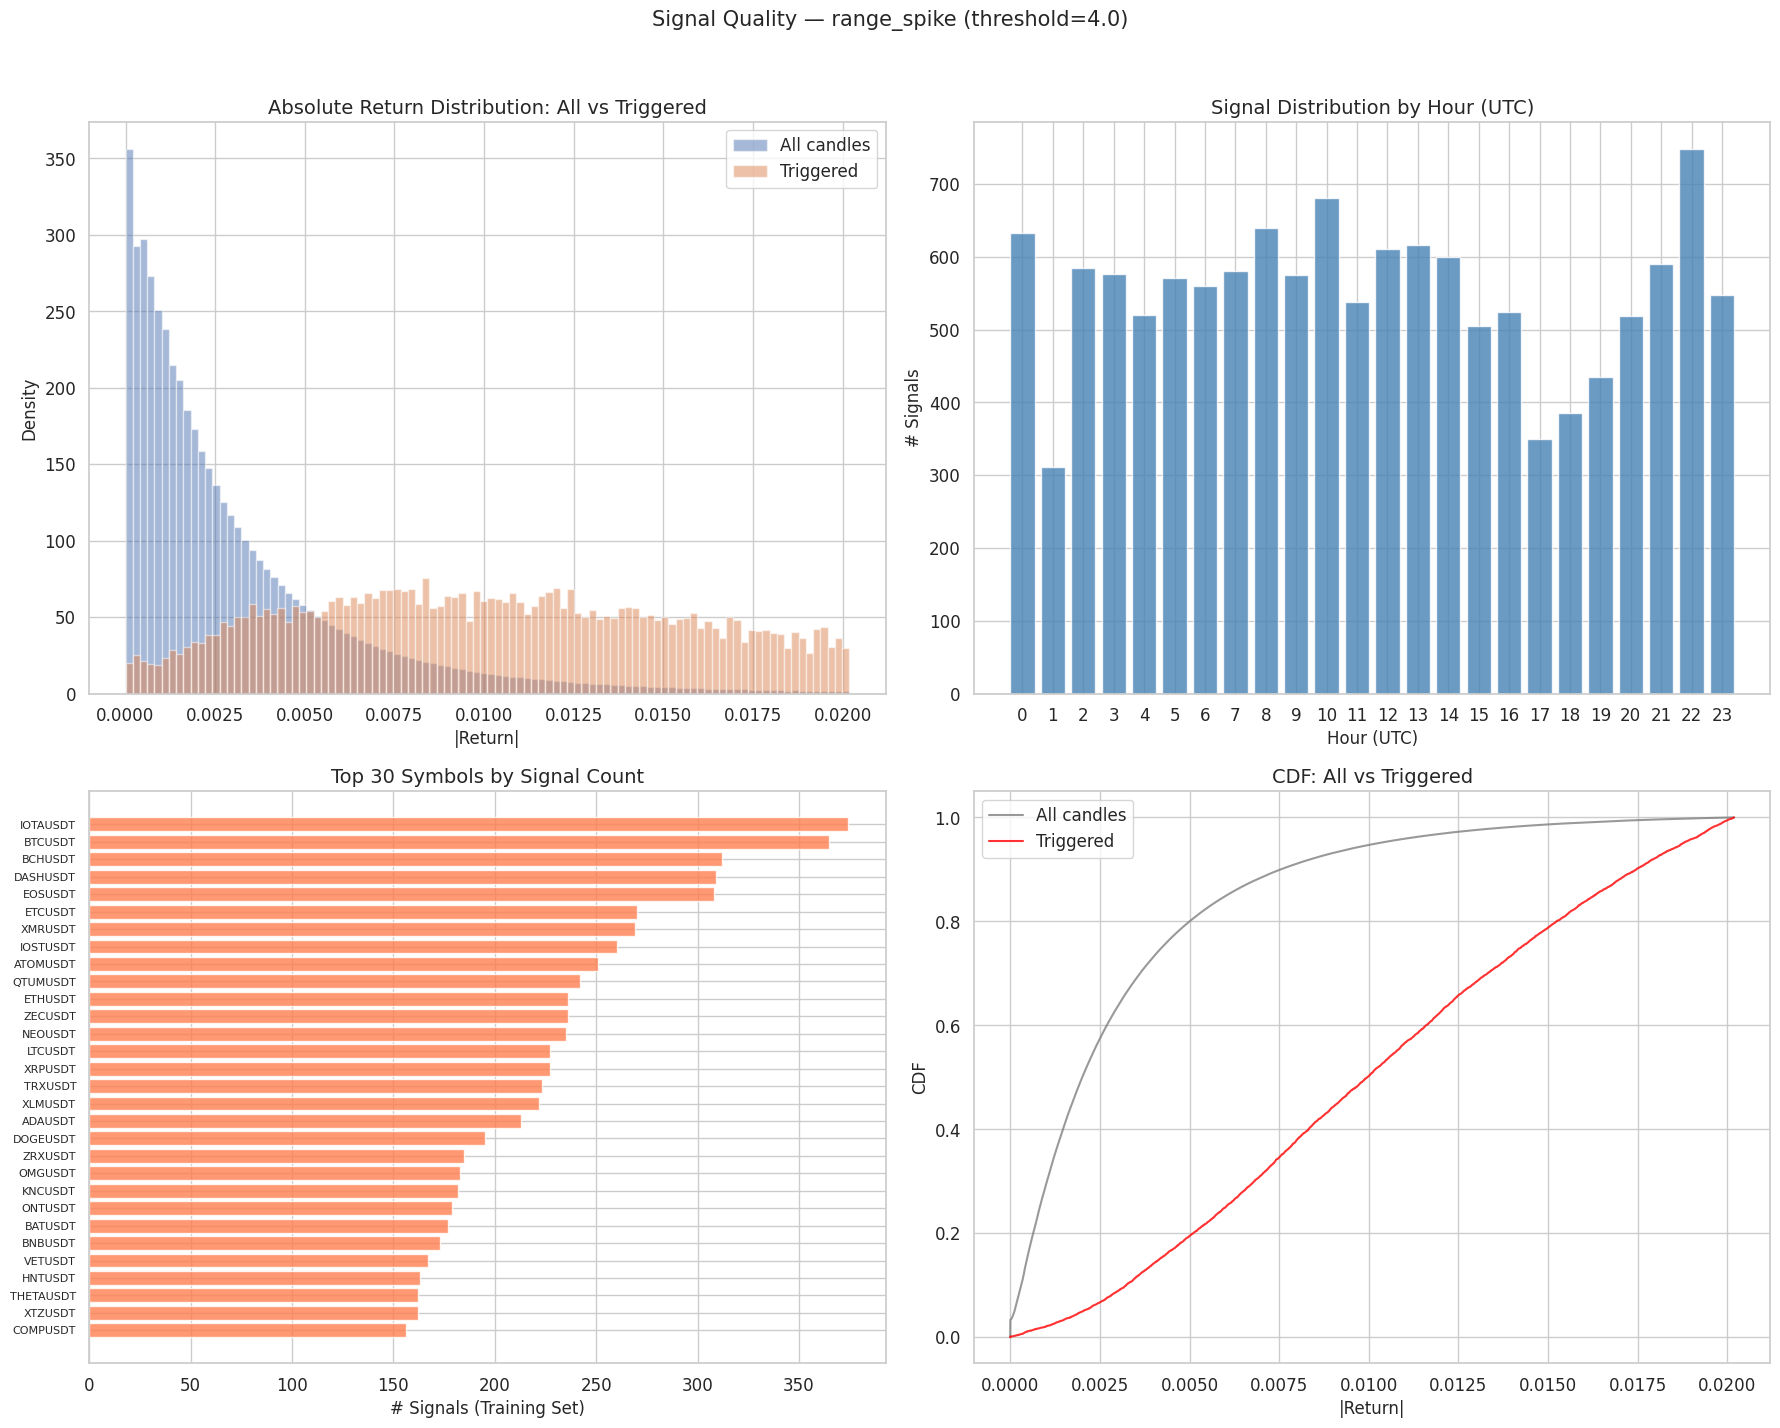

Saved threshold_signal_quality.png


In [40]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Return distribution comparison
ax = axes[0, 0]
clip = np.percentile(all_returns, 99)
ax.hist(all_returns[all_returns <= clip], bins=100, alpha=0.5, density=True, label="All candles")
ax.hist(triggered_returns[triggered_returns <= clip], bins=100, alpha=0.5, density=True, label="Triggered")
ax.set_xlabel("|Return|")
ax.set_ylabel("Density")
ax.set_title("Absolute Return Distribution: All vs Triggered")
ax.legend()

# 2. Hour-of-day distribution
ax = axes[0, 1]
hour_counts = pd.Series(triggered_hours).value_counts().sort_index()
ax.bar(hour_counts.index, hour_counts.values, color="steelblue", alpha=0.8)
ax.set_xlabel("Hour (UTC)")
ax.set_ylabel("# Signals")
ax.set_title("Signal Distribution by Hour (UTC)")
ax.set_xticks(range(24))

# 3. Per-symbol signal spread (top 30)
ax = axes[1, 0]
sym_counts = pd.Series(per_symbol_signal_count).sort_values(ascending=False)
top30 = sym_counts.head(30)
ax.barh(range(len(top30)), top30.values, color="coral", alpha=0.8)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30.index, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel("# Signals (Training Set)")
ax.set_title("Top 30 Symbols by Signal Count")

# 4. CDF comparison
ax = axes[1, 1]
for data, label, color in [
    (all_returns, "All candles", "gray"),
    (triggered_returns, "Triggered", "red"),
]:
    sorted_d = np.sort(data[data <= clip])
    cdf = np.arange(1, len(sorted_d) + 1) / len(sorted_d)
    ax.plot(sorted_d, cdf, label=label, color=color, alpha=0.8)
ax.set_xlabel("|Return|")
ax.set_ylabel("CDF")
ax.set_title("CDF: All vs Triggered")
ax.legend()

fig.suptitle(f"Signal Quality — {top_formula} (threshold={static_t})", fontsize=15, y=1.02)
plt.tight_layout()
fig.savefig(OUTPUT_DIR / "threshold_signal_quality.png")
plt.show()
print("Saved threshold_signal_quality.png")

## Section 9: Conclusions

In [41]:
# --- Final summary ---
print("=" * 80)
print("THRESHOLD ANALYSIS — SUMMARY")
print("=" * 80)

print(f"\n1. FORMULA RANKING (best to worst):")
for i, (metric, row) in enumerate(rank_df.iterrows(), 1):
    marker = " <<<" if metric == top_formula else ""
    print(f"   {i}. {metric:20s}  score={row['composite_score']:.3f}  "
          f"CV={row['avg_cv']:.1f}%  drift={row['abs_drift']:.1f}%  "
          f"target_err={row['target_err_pct']:.1f}%{marker}")

print(f"\n2. BEST FORMULA: {top_formula}")
print(f"   Threshold: {static_t}")
print(f"   Train avg: {comp_df.loc[top_formula, 'train_avg']:.0f} signals/month")
print(f"   Val avg:   {comp_df.loc[top_formula, 'val_avg']:.0f} signals/month")
print(f"   Drift:     {comp_df.loc[top_formula, 'drift_pct']:.1f}%")

print(f"\n3. STATIC vs DYNAMIC:")
for _, row in strat_df.iterrows():
    print(f"   {row.name:10s}: train={row['train_avg']:.0f}  val={row['val_avg']:.0f}  "
          f"drift={row['drift_pct']:.1f}%  CV(train)={row['train_cv_pct']:.1f}%  "
          f"CV(val)={row['val_cv_pct']:.1f}%")

# Determine recommendation
static_cv = strat_df.loc["static", "val_cv_pct"]
adaptive_cv = strat_df.loc["adaptive", "val_cv_pct"]
static_drift = abs(strat_df.loc["static", "drift_pct"])
adaptive_drift = abs(strat_df.loc["adaptive", "drift_pct"])

if adaptive_cv < static_cv and adaptive_drift < static_drift:
    recommendation = "ADAPTIVE (lower CV and lower drift)"
elif adaptive_cv < static_cv:
    recommendation = "ADAPTIVE (lower CV, more stable signal count)"
elif adaptive_drift < static_drift:
    recommendation = "ADAPTIVE (lower drift, better generalization)"
else:
    recommendation = "STATIC (simpler and performs comparably or better)"

print(f"\n4. RECOMMENDATION: {recommendation}")

print(f"\n5. SIGNAL QUALITY:")
print(f"   Triggered candles have {triggered_returns.mean()/all_returns.mean():.1f}x "
      f"larger absolute returns than average")
print(f"   Mean |return| — all: {all_returns.mean()*100:.4f}%  "
      f"triggered: {triggered_returns.mean()*100:.4f}%")

print(f"\n6. NEXT STEPS:")
print(f"   - Use {top_formula} with threshold={static_t} as the primary signal filter")
print(f"   - Test forward return windows (5m, 15m, 1h) after triggered candles")
print(f"   - Evaluate entry/exit strategies conditioned on threshold signals")
print(f"   - Consider combining top 2-3 formulas for higher-confidence signals")
print("\n" + "=" * 80)

THRESHOLD ANALYSIS — SUMMARY

1. FORMULA RANKING (best to worst):
   1. range_spike           score=0.067  CV=92.7%  drift=18.7%  target_err=8.4% <<<
   2. trade_spike           score=0.279  CV=94.0%  drift=42.8%  target_err=6.8%
   3. combined_z            score=0.306  CV=85.4%  drift=54.8%  target_err=295.3%
   4. qvol_spike            score=0.362  CV=101.7%  drift=44.3%  target_err=27.4%
   5. vol_spike             score=0.367  CV=101.8%  drift=44.8%  target_err=27.9%
   6. price_move            score=0.424  CV=129.2%  drift=20.6%  target_err=384.8%
   7. taker_imbalance       score=0.670  CV=93.8%  drift=54.0%  target_err=14425.0%

2. BEST FORMULA: range_spike
   Threshold: 4.0
   Train avg: 550 signals/month
   Val avg:   447 signals/month
   Drift:     -18.7%

3. STATIC vs DYNAMIC:
   static    : train=550  val=447  drift=-18.7%  CV(train)=70.9%  CV(val)=114.5%
   adaptive  : train=1030  val=995  drift=-3.4%  CV(train)=109.2%  CV(val)=133.5%

4. RECOMMENDATION: ADAPTIVE (lower dr